# Imports

In [25]:
import sys, os, time, copy, gc, math
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from pathlib import Path
import glob
import numpy as np
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
import multiprocessing as mp
import json
import shutil
from timm.layers import DropPath, trunc_normal_

from torcheval.metrics.functional import binary_auroc, multiclass_auroc

from sklearn.model_selection import StratifiedGroupKFold

import hashlib
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split

from PIL import Image
import torch.optim as optim

from collections import defaultdict


sys.path.append('../src')
from utils import set_seed, visualize_augmentations_positive, print_trainable_parameters
from models import setup_model
from training import fetch_scheduler, train_one_epoch, valid_one_epoch, run_training, get_nth_test_step, criterion, combined_criterion
from models import ISICModel, ISICModelSegL, ISICModelEdgnet, ISICModelEdgnetSegL, ISICModelEdgnet, setup_model
from datasets import ISICDatasetSamplerW, ISICDatasetSampler, ISICDatasetSimple, ISICDatasetSamplerMulticlass, prepare_loaders
from augmentations import get_augmentations

import warnings
warnings.filterwarnings("ignore")

# Configs

In [26]:
# Set up device and random seed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3090 Ti
Number of GPUs: 1


In [27]:
original_data_path = "../data/original"
original_root = Path('../data/original')

data_artifacts = "../data/artifacts"
os.makedirs(data_artifacts, exist_ok=True)

In [28]:
# Set the HDF5 file path
TRAIN_HDF5_FILE_PATH = original_root / 'train-image.hdf5'

train_path = original_root / 'train-metadata.csv'
df_train = pd.read_csv(train_path)
df_train["path"] = '../data/original/train-image/image/' + df_train['isic_id'] + ".jpg"
original_positive_cases = df_train['target'].sum()
original_total_cases = len(df_train)
original_positive_ratio = original_positive_cases / original_total_cases

print(f"Number of positive cases: {original_positive_cases}")
print(f"Number of negative cases: {original_total_cases - original_positive_cases}")
print(f"Ratio of negative to positive cases: {(original_total_cases - original_positive_cases) / original_positive_cases:.2f}:1")

Number of positive cases: 393
Number of negative cases: 400666
Ratio of negative to positive cases: 1019.51:1


In [29]:
MODEL_NAME = "EDGENEXT" 

CONFIG = {
    "seed": 1997,
    "epochs": 5,
    "img_size": 128,
    # "train_batch_size": 32,
    "valid_batch_size": 64,
    "train_batch_size": 2,
    "learning_rate": 1e-4,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 2000,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "group_col": 'patient_id',
    "device": device
}

model_name = "edgenext_base.in21k_ft_in1k"
checkpoint_path = None

# Utils

In [30]:
# =============================================================================
# 1. Utility Modules
# =============================================================================

# Custom LayerNorm that supports channels_last (default) and channels_first formats.
class LayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        """
        Args:
            normalized_shape (int): number of channels.
            eps (float): a value added for numerical stability.
            data_format (str): "channels_last" (e.g. (N, H, W, C)) or "channels_first" (e.g. (N, C, H, W)).
        """
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias   = nn.Parameter(torch.zeros(normalized_shape))
        self.eps    = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError("data_format must be either 'channels_last' or 'channels_first'")
        self.normalized_shape = (normalized_shape,)

    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        else:
            # For channels_first: x is (N, C, H, W)
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            # Weight and bias are reshaped for broadcast
            return self.weight[:, None, None] * (x - u) / torch.sqrt(s + self.eps) + self.bias[:, None, None]

# PositionalEncodingFourier used for some global blocks.
class PositionalEncodingFourier(nn.Module):
    def __init__(self, hidden_dim=32, dim=24, temperature=10000):
        super().__init__()
        self.token_projection = nn.Conv2d(hidden_dim * 2, dim, kernel_size=1)
        self.scale = 2 * math.pi
        self.temperature = temperature
        self.hidden_dim = hidden_dim
        self.dim = dim

    def forward(self, B, H, W):
        mask = torch.zeros(B, H, W).bool().to(self.token_projection.weight.device)
        not_mask = ~mask
        y_embed = not_mask.cumsum(1, dtype=torch.float32)
        x_embed = not_mask.cumsum(2, dtype=torch.float32)
        eps = 1e-6
        y_embed = y_embed / (y_embed[:, -1:, :] + eps) * self.scale
        x_embed = x_embed / (x_embed[:, :, -1:] + eps) * self.scale
        dim_t = torch.arange(self.hidden_dim, dtype=torch.float32, device=mask.device)
        dim_t = self.temperature ** (2 * (dim_t // 2) / self.hidden_dim)
        pos_x = x_embed[:, :, :, None] / dim_t
        pos_y = y_embed[:, :, :, None] / dim_t
        pos_x = torch.stack((pos_x[:, :, :, 0::2].sin(),
                             pos_x[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos_y = torch.stack((pos_y[:, :, :, 0::2].sin(),
                             pos_y[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos = torch.cat((pos_y, pos_x), dim=3).permute(0, 3, 1, 2)
        pos = self.token_projection(pos)
        return pos
    
class XCA(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        self.temperature = nn.Parameter(torch.ones(num_heads, 1, 1))
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        q = q.transpose(-2, -1)
        k = k.transpose(-2, -1)
        v = v.transpose(-2, -1)
        q = F.normalize(q, dim=-1)
        k = F.normalize(k, dim=-1)
        attn = (q @ k.transpose(-2, -1)) * self.temperature
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = (attn @ v).permute(0, 3, 1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x
    
    @torch.jit.ignore
    def no_weight_decay(self):
        return {'temperature'}


# EdgeNeXt

In [31]:
# =============================================================================
# 2. EdgeNeXt Encoder (Adapted to return multi-scale features)
# =============================================================================

# --- ConvEncoder and SDTAEncoder for local and global blocks ---
class ConvEncoder(nn.Module):
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6, expan_ratio=4, kernel_size=7):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=kernel_size, padding=kernel_size // 2, groups=dim)
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, expan_ratio * dim)
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(expan_ratio * dim, dim)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones(dim),
                                  requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        # Rearranging for LayerNorm and Linear (channels_last)
        x = x.permute(0, 2, 3, 1)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2)
        x = input + self.drop_path(x)
        return x


class SDTAEncoder(nn.Module):
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6, expan_ratio=4,
                 use_pos_emb=True, num_heads=8, qkv_bias=True, attn_drop=0., drop=0., scales=1):
        super().__init__()
        width = max(int(math.ceil(dim / scales)), int(math.floor(dim / scales)))
        self.width = width
        self.nums = 1 if scales == 1 else scales - 1
        convs = [nn.Conv2d(width, width, kernel_size=3, padding=1, groups=width) for _ in range(self.nums)]
        self.convs = nn.ModuleList(convs)
        self.pos_embd = PositionalEncodingFourier(dim=dim) if use_pos_emb else None
        self.norm_xca = LayerNorm(dim, eps=1e-6)
        self.gamma_xca = nn.Parameter(layer_scale_init_value * torch.ones(dim),
                                      requires_grad=True) if layer_scale_init_value > 0 else None
        self.xca = XCA(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, expan_ratio * dim)
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(expan_ratio * dim, dim)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones(dim),
                                  requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        spx = torch.split(x, self.width, 1)
        for i in range(self.nums):
            sp = spx[0] if i == 0 else sp + spx[i]
            sp = self.convs[i](sp)
            out = sp if i == 0 else torch.cat((out, sp), 1)
        x = torch.cat((out, spx[self.nums]), 1)
        B, C, H, W = x.shape
        x = x.reshape(B, C, H * W).permute(0, 2, 1)
        if self.pos_embd:
            pos_encoding = self.pos_embd(B, H, W).reshape(B, -1, x.shape[1]).permute(0, 2, 1)
            x = x + pos_encoding
        x = x + self.drop_path(self.gamma_xca * self.xca(self.norm_xca(x)))
        x = x.reshape(B, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2)
        x = input + self.drop_path(x)
        return x
    
    # --- EdgeNeXt Encoder definition ---

class EdgeNeXt(nn.Module):
    def __init__(self, in_chans=3, num_classes=1000,
                 depths=[3, 3, 9, 3], dims=[80, 160, 288, 584],
                 global_block=[0, 1, 1, 1], global_block_type=['None', 'SDTA', 'SDTA', 'SDTA'],
                 drop_path_rate=0., layer_scale_init_value=1e-6, head_init_scale=1., expan_ratio=4,
                 kernel_sizes=[3, 5, 7, 9], heads=[8, 8, 8, 8], use_pos_embd_xca=[False, True, False, False],
                 use_pos_embd_global=False, d2_scales=[2, 2, 3, 4], classifier_dropout=0.0, **kwargs):
        super().__init__()
        for g in global_block_type:
            assert g in ['None', 'SDTA']
        if use_pos_embd_global:
            self.pos_embd = PositionalEncodingFourier(dim=dims[0])
        else:
            self.pos_embd = None
        self.downsample_layers = nn.ModuleList()
        # Stem
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
        )
        # Modified Stem: gradual downsampling from 256×256 -> 128×128 -> 64×64
        # stem = nn.Sequential(
        #     nn.Conv2d(in_chans, dims[0], kernel_size=2, stride=2),  # 256 -> 128
        #     nn.BatchNorm2d(dims[0]),
        #     nn.Conv2d(dims[0], dims[0], kernel_size=2, stride=2),     # 128 -> 64
        #     nn.BatchNorm2d(dims[0])
        # )

        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2)
            )
            self.downsample_layers.append(downsample_layer)
        self.stages = nn.ModuleList()
        # total_blocks = sum(depths)
        dp_rates = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        cur = 0
        self.num_stages = 4
        for i in range(4):
            stage_blocks = []
            for j in range(depths[i]):
                if j > depths[i] - global_block[i] - 1:
                    if global_block_type[i] == 'SDTA':
                        stage_blocks.append(
                            SDTAEncoder(dim=dims[i], drop_path=dp_rates[cur+j],
                                        expan_ratio=expan_ratio, scales=d2_scales[i],
                                        use_pos_emb=use_pos_embd_xca[i], num_heads=heads[i])
                        )
                    else:
                        raise NotImplementedError
                else:
                    stage_blocks.append(
                        ConvEncoder(dim=dims[i], drop_path=dp_rates[cur+j],
                                    layer_scale_init_value=layer_scale_init_value,
                                    expan_ratio=expan_ratio, kernel_size=kernel_sizes[i])
                    )
            self.stages.append(nn.Sequential(*stage_blocks))
            cur += depths[i]
        self.norm = nn.LayerNorm(dims[-1], eps=1e-6)
        self.head = nn.Linear(dims[-1], num_classes)
        self.head_dropout = nn.Dropout(classifier_dropout)
        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, (LayerNorm, nn.LayerNorm)):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    # Modified forward_features to optionally return intermediate features.
    def forward_features(self, x, return_intermediate=False):
        features = []
        x = self.downsample_layers[0](x)
        x = self.stages[0](x)
        if self.pos_embd:
            B, C, H, W = x.shape
            x = x + self.pos_embd(B, H, W)
        if return_intermediate:
            features.append(x)
            # features['stage0'] = x
        for i in range(1, 4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
            if return_intermediate:
                features.append(x)
                # features[f'stage{i}'] = x
        if return_intermediate:
            return features
        else:
            x = self.norm(x.mean([-2, -1]))
            return x

    # Forward method with seg flag: seg=True returns (cls_logits, multi-scale_feats)
    def forward(self, x, seg=False):
        if seg:
            feats = self.forward_features(x, return_intermediate=True)
            # For classification, use the deepest feature.
            cls_feat = feats[-1].mean([-2, -1])
            cls_out = self.head(self.head_dropout(self.norm(cls_feat)))
            return cls_out, feats
        else:
            x = self.forward_features(x, return_intermediate=False)
            x = self.head(self.head_dropout(x))
            return x

# EdgeNeXtBNHS

In [32]:
class ConvEncoderBNHS(nn.Module):
    """
        Conv. Encoder with Batch Norm and Hard-Swish Activation
    """
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6, expan_ratio=4, kernel_size=7):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=kernel_size, padding=kernel_size // 2, groups=dim, bias=False)
        self.norm = nn.BatchNorm2d(dim)
        self.pwconv1 = nn.Linear(dim, expan_ratio * dim)
        self.act = nn.Hardswish()
        self.pwconv2 = nn.Linear(expan_ratio * dim, dim)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones(dim),
                                  requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = self.norm(x)
        x = x.permute(0, 2, 3, 1)  # (N, C, H, W) -> (N, H, W, C)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x

class SDTAEncoderBNHS(nn.Module):
    """
        SDTA Encoder with Batch Norm and Hard-Swish Activation
    """
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6, expan_ratio=4,
                 use_pos_emb=True, num_heads=8, qkv_bias=True, attn_drop=0., drop=0., scales=1):
        super().__init__()
        width = max(int(math.ceil(dim / scales)), int(math.floor(dim // scales)))
        self.width = width
        if scales == 1:
            self.nums = 1
        else:
            self.nums = scales - 1
        convs = []
        for i in range(self.nums):
            convs.append(nn.Conv2d(width, width, kernel_size=3, padding=1, groups=width))
        self.convs = nn.ModuleList(convs)

        self.pos_embd = None
        if use_pos_emb:
            self.pos_embd = PositionalEncodingFourier(dim=dim)
        self.norm_xca = nn.BatchNorm2d(dim)
        self.gamma_xca = nn.Parameter(layer_scale_init_value * torch.ones(dim),
                                      requires_grad=True) if layer_scale_init_value > 0 else None
        self.xca = XCA(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)

        self.norm = nn.BatchNorm2d(dim)
        self.pwconv1 = nn.Linear(dim, expan_ratio * dim)  # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.Hardswish()  # TODO: MobileViT is using 'swish'
        self.pwconv2 = nn.Linear(expan_ratio * dim, dim)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim)),
                                  requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x

        spx = torch.split(x, self.width, 1)
        for i in range(self.nums):
            if i == 0:
                sp = spx[i]
            else:
                sp = sp + spx[i]
            sp = self.convs[i](sp)
            if i == 0:
                out = sp
            else:
                out = torch.cat((out, sp), 1)
        x = torch.cat((out, spx[self.nums]), 1)
        # XCA
        x = self.norm_xca(x)
        B, C, H, W = x.shape
        x = x.reshape(B, C, H * W).permute(0, 2, 1)
        if self.pos_embd:
            pos_encoding = self.pos_embd(B, H, W).reshape(B, -1, x.shape[1]).permute(0, 2, 1)
            x = x + pos_encoding
        x = x + self.drop_path(self.gamma_xca * self.xca(x))
        x = x.reshape(B, H, W, C).permute(0, 3, 1, 2)

        # Inverted Bottleneck
        x = self.norm(x)
        x = x.permute(0, 2, 3, 1)  # (N, C, H, W) -> (N, H, W, C)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)

        return x


class EdgeNeXtBNHS(nn.Module):
    def __init__(self, in_chans=3, num_classes=1000,
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768],
                 global_block=[0, 0, 0, 3], global_block_type=['None', 'None', 'None', 'SDTA_BN_HS'],
                 drop_path_rate=0., layer_scale_init_value=1e-6, head_init_scale=1., expan_ratio=4,
                 kernel_sizes=[7, 7, 7, 7], heads=[8, 8, 8, 8], use_pos_embd_xca=[False, False, False, False],
                 use_pos_embd_global=False, d2_scales=[2, 3, 4, 5], **kwargs):
        super().__init__()
        for g in global_block_type:
            assert g in ['None', 'SDTA_BN_HS']

        if use_pos_embd_global:
            self.pos_embd = PositionalEncodingFourier(dim=dims[0])
        else:
            self.pos_embd = None

        self.downsample_layers = nn.ModuleList()  # stem and 3 intermediate downsampling conv layers
        # stem = nn.Sequential(
        #     nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4, bias=False),
        #     nn.BatchNorm2d(dims[0])
        # )
        # Modified Stem: gradual downsampling from 256×256 -> 128×128 -> 64×64
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=2, stride=2),  # 256 -> 128
            nn.BatchNorm2d(dims[0]),
            nn.Conv2d(dims[0], dims[0], kernel_size=2, stride=2),     # 128 -> 64
            nn.BatchNorm2d(dims[0])
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                nn.BatchNorm2d(dims[i]),
                nn.Conv2d(dims[i], dims[i + 1], kernel_size=2, stride=2, bias=False),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList()  # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        cur = 0
        for i in range(4):
            stage_blocks = []
            for j in range(depths[i]):
                if j > depths[i] - global_block[i] - 1:
                    if global_block_type[i] == 'SDTA_BN_HS':
                        stage_blocks.append(SDTAEncoderBNHS(dim=dims[i], drop_path=dp_rates[cur + j],
                                                            expan_ratio=expan_ratio, scales=d2_scales[i],
                                                            use_pos_emb=use_pos_embd_xca[i],
                                                            num_heads=heads[i]))
                    else:
                        raise NotImplementedError
                else:
                    stage_blocks.append(ConvEncoderBNHS(dim=dims[i], drop_path=dp_rates[cur + j],
                                                        layer_scale_init_value=layer_scale_init_value,
                                                        expan_ratio=expan_ratio, kernel_size=kernel_sizes[i]))

            self.stages.append(nn.Sequential(*stage_blocks))
            cur += depths[i]
        self.norm = nn.BatchNorm2d(dims[-1])
        self.head = nn.Linear(dims[-1], num_classes)

        self.apply(self._init_weights)
        self.head_dropout = nn.Dropout(kwargs["classifier_dropout"])
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    def _init_weights(self, m):  # TODO: MobileViT is using 'kaiming_normal' for initializing conv layers
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, (LayerNorm, nn.LayerNorm)):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward_features(self, x, return_intermediate=False):
        """
        Modified to support returning multi-scale features.
        If return_intermediate=True, returns a list of features from each stage.
        Otherwise, returns the global-pooled final feature.
        """
        features = []
        x = self.downsample_layers[0](x)
        x = self.stages[0](x)
        if self.pos_embd:
            B, C, H, W = x.shape
            x = x + self.pos_embd(B, H, W)
        if return_intermediate:
            # features.append(x)
            features['stage0'] = x
        for i in range(1, 4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
            if return_intermediate:
                # features.append(x)
                features[f'stage{i}'] = x
        if return_intermediate:
            return features
        else:
            x = self.norm(x).mean([-2, -1])
            return x

    def forward(self, x, seg=False):
        """
        Args:
            x: Input tensor of shape (N, in_chans, H, W)
            seg (bool): If True, returns (cls_logits, multi-scale_features);
                        if False, returns classification logits only.
        """
        if seg:
            feats = self.forward_features(x, return_intermediate=True)
            # For classification, use the deepest feature map.
            cls_feat = feats[-1].mean([-2, -1])
            cls_out = self.head(self.head_dropout(cls_feat))
            return cls_out, feats
        else:
            x = self.forward_features(x, return_intermediate=False)
            x = self.head(self.head_dropout(x))
            return x

# Unet Decoder

In [33]:
# # =============================================================================
# # 3. Segmentation Decoder (U-Net Style)
# # =============================================================================

# class SegmentationDecoder(nn.Module):
#     """
#     U-Net style segmentation decoder that fuses multi-scale features from the encoder.
#     It projects each encoder feature to a common channel space, then upsamples and fuses using skip connections.
#     """
#     def __init__(self, in_dims, proj_channels=64, num_seg_classes=1):
#         """
#         Args:
#             in_dims (list[int]): list of channel dimensions from the encoder (e.g. [d0, d1, d2, d3]).
#             proj_channels (int): common projection channel dimension used in decoder.
#             num_seg_classes (int): number of segmentation classes (output channels).
#         """
#         super().__init__()
#         self.proj0 = nn.Conv2d(in_dims[0], proj_channels, kernel_size=1)
#         self.proj1 = nn.Conv2d(in_dims[1], proj_channels, kernel_size=1)
#         self.proj2 = nn.Conv2d(in_dims[2], proj_channels, kernel_size=1)
#         self.proj3 = nn.Conv2d(in_dims[3], proj_channels, kernel_size=1)
#         self.up1 = nn.Sequential(
#             nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
#             nn.Conv2d(proj_channels, proj_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(proj_channels),
#             nn.ReLU(inplace=True)
#         )
#         self.fuse1 = nn.Conv2d(proj_channels * 2, proj_channels, kernel_size=3, padding=1)
#         self.up2 = nn.Sequential(
#             nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
#             nn.Conv2d(proj_channels, proj_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(proj_channels),
#             nn.ReLU(inplace=True)
#         )
#         self.fuse2 = nn.Conv2d(proj_channels * 2, proj_channels, kernel_size=3, padding=1)
#         self.up3 = nn.Sequential(
#             nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
#             nn.Conv2d(proj_channels, proj_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(proj_channels),
#             nn.ReLU(inplace=True)
#         )
#         self.fuse3 = nn.Conv2d(proj_channels * 2, proj_channels, kernel_size=3, padding=1)
#         self.final_up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
#         self.out_conv = nn.Conv2d(proj_channels, num_seg_classes, kernel_size=1)

#     def forward(self, feats):
#         # feats: list [f0, f1, f2, f3] from encoder.
#         x0 = self.proj0(feats[0])
#         x1 = self.proj1(feats[1])
#         x2 = self.proj2(feats[2])
#         x3 = self.proj3(feats[3])
#         # Up 1: upsample x3, fuse with x2.
#         x = self.up1(x3)
#         if x.shape[2:] != x2.shape[2:]:
#             diffY = x2.size(2) - x.size(2)
#             diffX = x2.size(3) - x.size(3)
#             x = F.pad(x, [diffX // 2, diffX - diffX // 2,
#                           diffY // 2, diffY - diffY // 2])
#         x = torch.cat([x2, x], dim=1)
#         x = self.fuse1(x)
#         # Up 2: upsample and fuse with x1.
#         x = self.up2(x)
#         if x.shape[2:] != x1.shape[2:]:
#             diffY = x1.size(2) - x.size(2)
#             diffX = x1.size(3) - x.size(3)
#             x = F.pad(x, [diffX // 2, diffX - diffX // 2,
#                           diffY // 2, diffY - diffY // 2])
#         x = torch.cat([x1, x], dim=1)
#         x = self.fuse2(x)
#         # Up 3: upsample and fuse with x0.
#         x = self.up3(x)
#         if x.shape[2:] != x0.shape[2:]:
#             diffY = x0.size(2) - x.size(2)
#             diffX = x0.size(3) - x.size(3)
#             x = F.pad(x, [diffX // 2, diffX - diffX // 2,
#                           diffY // 2, diffY - diffY // 2])
#         x = torch.cat([x0, x], dim=1)
#         x = self.fuse3(x)
#         x = self.final_up(x)
#         seg_out = self.out_conv(x)
#         return seg_out


In [34]:
# # =============================================================================
# # 3. Segmentation Decoder (U-Net Style)
# # =============================================================================

class SegmentationDecoder(nn.Module):
    """
    U-Net style segmentation decoder that fuses multi-scale features from the encoder.
    It projects each encoder feature to a common channel space, then upsamples and fuses
    using skip connections. This version expects the encoder to return a list of features.
    """
    def __init__(self, in_dims, proj_channels=64, num_seg_classes=1):
        """
        Args:
            in_dims (list[int]): list of channel dimensions from the encoder (e.g. [d0, d1, d2, d3]).
            proj_channels (int): common projection channel dimension used in the decoder.
            num_seg_classes (int): number of segmentation classes (output channels).
        """
        super().__init__()
        # Projection layers stored in a ModuleList.
        self.projs = nn.ModuleList([
            nn.Conv2d(dim, proj_channels, kernel_size=1) for dim in in_dims
        ])
        
        # Upsampling blocks stored in a ModuleList.
        # There are 3 upsampling steps if we have 4 feature levels.
        self.up_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                nn.Conv2d(proj_channels, proj_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(proj_channels),
                nn.ReLU(inplace=True)
            ) for _ in range(3)
        ])
        
        # Fusion layers stored in a ModuleList.
        self.fuse_layers = nn.ModuleList([
            nn.Conv2d(proj_channels * 2, proj_channels, kernel_size=3, padding=1) for _ in range(3)
        ])
        
        # Final upsampling layers.
        self.final_up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(proj_channels, proj_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(proj_channels),
            nn.ReLU(inplace=True)
        )
        # Extra upsampling block to reach input resolution.
        self.final_up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        self.out_conv = nn.Conv2d(proj_channels, num_seg_classes, kernel_size=1)

    def _pad_and_cat(self, x, skip):
        """Pad x if necessary and concatenate with skip along the channel dimension."""
        if x.shape[2:] != skip.shape[2:]:
            diffY = skip.size(2) - x.size(2)
            diffX = skip.size(3) - x.size(3)
            x = F.pad(x, [diffX // 2, diffX - diffX // 2,
                          diffY // 2, diffY - diffY // 2])
        return torch.cat([skip, x], dim=1)

    def forward(self, feats):
        """
        Args:
            feats (list[Tensor]): List of encoder feature maps in order [f0, f1, f2, f3],
                                  where f0 is the highest resolution and f3 is the lowest.
        Returns:
            seg_out (Tensor): Segmentation output.
        """
        # Apply projection layers to convert features to proj_channels.
        proj_feats = [proj(feat) for proj, feat in zip(self.projs, feats)]
        # Assuming proj_feats[0] is stage0, proj_feats[1] stage1, proj_feats[2] stage2, proj_feats[3] stage3.
        # Start with the lowest resolution.
        x = proj_feats[3]
        print(x.shape)
        # Upsample and fuse with stage2.
        x = self.up_blocks[0](x)
        print(x.shape)

        x = self._pad_and_cat(x, proj_feats[2])
        x = self.fuse_layers[0](x)
        print(x.shape)

        # Upsample and fuse with stage1.
        x = self.up_blocks[1](x)
        print(x.shape)

        x = self._pad_and_cat(x, proj_feats[1])
        x = self.fuse_layers[1](x)
        print(x.shape)
        
        # Upsample and fuse with stage0.
        x = self.up_blocks[2](x)
        print(x.shape)

        x = self._pad_and_cat(x, proj_feats[0])
        x = self.fuse_layers[2](x)
        print(x.shape)

        # Final upsampling: first to 128x128, then to 256x256.
        x = self.final_up1(x)
        print(x.shape)
        x = self.final_up2(x)
        print(x.shape)

        
        seg_out = self.out_conv(x)
        return seg_out


In [35]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# # -------------------------------
# # CBAM Attention Module (unchanged)
# # -------------------------------
# class CBAM(nn.Module):
#     def __init__(self, channels, reduction_ratio=16, kernel_size=7):
#         """
#         Convolutional Block Attention Module.
        
#         Args:
#             channels (int): Number of input channels.
#             reduction_ratio (int): Channel reduction ratio.
#             kernel_size (int): Kernel size for spatial attention.
#         """
#         super(CBAM, self).__init__()
#         # Channel Attention
#         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.max_pool = nn.AdaptiveMaxPool2d(1)
#         self.fc = nn.Sequential(
#             nn.Conv2d(channels, channels // reduction_ratio, kernel_size=1, bias=False),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(channels // reduction_ratio, channels, kernel_size=1, bias=False)
#         )
#         self.sigmoid_channel = nn.Sigmoid()
        
#         # Spatial Attention
#         self.spatial = nn.Sequential(
#             nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False),
#             nn.Sigmoid()
#         )
        
#     def forward(self, x):
#         # ----- Channel Attention -----
#         avg_out = self.fc(self.avg_pool(x))
#         max_out = self.fc(self.max_pool(x))
#         channel_att = self.sigmoid_channel(avg_out + max_out)
#         x = x * channel_att
        
#         # ----- Spatial Attention -----
#         avg_out = torch.mean(x, dim=1, keepdim=True)
#         max_out, _ = torch.max(x, dim=1, keepdim=True)
#         spatial_att = self.spatial(torch.cat([avg_out, max_out], dim=1))
#         x = x * spatial_att
        
#         return x

# # -------------------------------
# # MultiRes Block (unchanged)
# # -------------------------------
# class MultiResBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, alpha=1.67):
#         """
#         A MultiRes block that performs multi-scale feature extraction and fuses via a residual shortcut.
        
#         Args:
#             in_channels (int): Number of input channels.
#             out_channels (int): Desired output channel count.
#             alpha (float): Scaling factor to compute the number of intermediate filters.
#         """
#         super(MultiResBlock, self).__init__()
#         W = out_channels * alpha
#         self.branch1_channels = int(W * 0.167)
#         self.branch2_channels = int(W * 0.333)
#         self.branch3_channels = int(W * 0.5)
        
#         self.conv3x3_1 = nn.Conv2d(in_channels, self.branch1_channels, kernel_size=3, padding=1)
#         self.conv3x3_2 = nn.Conv2d(self.branch1_channels, self.branch2_channels, kernel_size=3, padding=1)
#         self.conv3x3_3 = nn.Conv2d(self.branch2_channels, self.branch3_channels, kernel_size=3, padding=1)
        
#         # BatchNorm after concatenation of branches.
#         self.bn = nn.BatchNorm2d(self.branch1_channels + self.branch2_channels + self.branch3_channels)
#         # Shortcut projection
#         self.shortcut = nn.Conv2d(in_channels, self.branch1_channels + self.branch2_channels + self.branch3_channels, kernel_size=1)
#         self.relu = nn.ReLU(inplace=True)
#         # Final 1x1 convolution to get the desired output channels.
#         self.out_conv = nn.Conv2d(self.branch1_channels + self.branch2_channels + self.branch3_channels, out_channels, kernel_size=1)
        
#     def forward(self, x):
#         shortcut = self.shortcut(x)
#         x1 = self.relu(self.conv3x3_1(x))
#         x2 = self.relu(self.conv3x3_2(x1))
#         x3 = self.relu(self.conv3x3_3(x2))
#         # Concatenate outputs from the branches
#         out = torch.cat([x1, x2, x3], dim=1)
#         out = self.bn(out)
#         out = self.relu(out + shortcut)
#         out = self.out_conv(out)
#         return out

# # -------------------------------
# # Helper: Padding and Concatenation
# # -------------------------------
# def pad_and_cat(x, skip):
#     """Pad x to match the spatial dimensions of skip, then concatenate along the channel dimension."""
#     if x.shape[2:] != skip.shape[2:]:
#         diffY = skip.size(2) - x.size(2)
#         diffX = skip.size(3) - x.size(3)
#         x = F.pad(x, [diffX // 2, diffX - diffX // 2,
#                       diffY // 2, diffY - diffY // 2])
#     return torch.cat([skip, x], dim=1)

# # -------------------------------
# # Decoder Block: Upsample, Fuse, MultiRes & CBAM
# # -------------------------------
# class DecoderBlock(nn.Module):
#     def __init__(self, in_channels, skip_channels, out_channels):
#         """
#         A decoder block that upsamples the input, concatenates with the skip connection,
#         and applies a fusion convolution followed by a MultiRes block and CBAM attention.
        
#         Args:
#             in_channels (int): Number of channels in the low-resolution input.
#             skip_channels (int): Number of channels in the corresponding encoder skip connection.
#             out_channels (int): Desired output channel count for this block.
#         """
#         super(DecoderBlock, self).__init__()
#         self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
#         # After upsampling, the concatenated channels will be (in_channels + skip_channels)
#         self.fuse_conv = nn.Sequential(
#             nn.Conv2d(in_channels + skip_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )
#         # Use a MultiRes block on the fused feature.
#         self.multi_res = MultiResBlock(out_channels, out_channels)
#         # Apply CBAM attention.
#         self.cbam = CBAM(out_channels)
        
#     def forward(self, x, skip):
#         x = self.upsample(x)
#         print(x.shape)
#         # Pad if necessary and concatenate
#         x = pad_and_cat(x, skip)
#         print(x.shape)
#         x = self.fuse_conv(x)
#         print(x.shape)
#         x = self.multi_res(x)
#         print(x.shape)
#         x = self.cbam(x)

#         return x

# # -------------------------------
# # Segmentation Decoder with Varying Channels
# # -------------------------------
# class SegmentationDecoder(nn.Module):
#     def __init__(self, encoder_channels, num_seg_classes=1):
#         """
#         Decoder that fuses encoder features of varying channel dimensions.
#         For an encoder with features [f0, f1, f2, f3] (f0: highest resolution),
#         we design the decoder in a symmetric fashion:
#             - Use f3 as the starting feature.
#             - Fuse with f2 to produce an output with f2 channels.
#             - Fuse with f1 to produce an output with f1 channels.
#             - Fuse with f0 to produce an output with f0 channels.
#         A final upsampling layer and segmentation head produce the logits.
        
#         Args:
#             encoder_channels (list[int]): List of channel dimensions from the encoder in order [f0, f1, ..., fN].
#             num_seg_classes (int): Number of segmentation classes (output channels).
#         """
#         super(SegmentationDecoder, self).__init__()
        
#         # Assume encoder_channels = [f0, f1, f2, f3] where f0 is highest resolution.
#         self.f0, self.f1, self.f2, self.f3 = encoder_channels
        
#         # Stage 1: fuse f3 (lowest resolution) with f2.
#         self.block1 = DecoderBlock(in_channels=self.f3, skip_channels=self.f2, out_channels=self.f2)
#         # Stage 2: fuse output of block1 with f1.
#         self.block2 = DecoderBlock(in_channels=self.f2, skip_channels=self.f1, out_channels=self.f1)
#         # Stage 3: fuse output of block2 with f0.
#         self.block3 = DecoderBlock(in_channels=self.f1, skip_channels=self.f0, out_channels=self.f0)
        
#         # Final upsampling if needed. Here we assume f0 resolution is not the full input resolution.
#         self.final_upsample = nn.Sequential(
#             nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
#             nn.Conv2d(self.f0, self.f0, kernel_size=3, padding=1),
#             nn.BatchNorm2d(self.f0),
#             nn.ReLU(inplace=True),
#             # Additional upsampling block
#             nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
#             nn.Conv2d(self.f0, self.f0, kernel_size=3, padding=1),
#             nn.BatchNorm2d(self.f0),
#             nn.ReLU(inplace=True)
#         )
#         # Final segmentation head.
#         self.out_conv = nn.Conv2d(self.f0, num_seg_classes, kernel_size=1)

#     def forward(self, feats):
#         """
#         Args:
#             feats (list[Tensor]): List of encoder features in order [f0, f1, f2, f3],
#                                    with varying channel dimensions.
#         Returns:
#             seg_out (Tensor): Segmentation output.
#         """
#         # Unpack encoder features.
#         f0, f1, f2, f3 = feats
        
#         # Start at the bottleneck: use f3 directly.
#         x = f3
#         print(x.shape)
#         # Stage 1: Upsample and fuse with f2.
#         x = self.block1(x, f2)
#         print(x.shape)
#         # Stage 2: Upsample and fuse with f1.
#         x = self.block2(x, f1)
#         print(x.shape)

#         # Stage 3: Upsample and fuse with f0.
#         x = self.block3(x, f0)
#         print(x.shape)

#         # Optional final upsampling to reach desired output resolution.
#         x = self.final_upsample(x)
#         print(x.shape)

#         seg_out = self.out_conv(x)
#         return seg_out

# Segmentation Assisted Classification (SAC)

In [36]:
# # =============================================================================
# # Modified Segmentation Assisted Classification Model using EdgeNeXtBNHS
# # =============================================================================

# class SegmentationAssistedClassificationModel(nn.Module):
#     def __init__(self, in_chans=3, num_classes=2, num_seg_classes=1,
#                  encoder_kwargs=None, decoder_proj_channels=64, **kwargs):
#         """
#         Args:
#             in_chans (int): Number of input channels.
#             num_classes (int): Number of classification classes (2 for binary classification).
#             num_seg_classes (int): Number of segmentation output channels (1 for binary segmentation).
#             encoder_kwargs (dict): Dictionary of arguments to configure the EdgeNeXt encoder.
#             decoder_proj_channels (int): Number of channels to which each encoder feature is projected in the decoder.
#         """
#         super().__init__()
#         if encoder_kwargs is None:
#             # Default: Use the edgenext_base config.
#             encoder_kwargs = {
#                 "depths": [3, 3, 9, 3],
#                 "dims": [80, 160, 288, 584],
#                 "expan_ratio": 4,
#                 "global_block": [0, 1, 1, 1],
#                 "global_block_type": ['None', 'SDTA', 'SDTA', 'SDTA'],
#                 # "global_block_type": ['None', 'SDTA_BN_HS', 'SDTA_BN_HS', 'SDTA_BN_HS'],  # Changed here
#                 "use_pos_embd_xca": [False, True, False, False],
#                 "kernel_sizes": [3, 5, 7, 9],
#                 "d2_scales": [2, 2, 3, 4],
#                 "classifier_dropout": 0.1,
#                 "heads": [4, 4, 4, 4]
#             }
#         # Import your EdgeNeXt implementation (or EdgeNeXtBNHS if that is your variant)

#         # Instantiate the encoder using the edgenext_base configuration.
#         self.encoder = EdgeNeXt(in_chans=in_chans, num_classes=num_classes, **encoder_kwargs)
#         # The segmentation decoder expects a list of multi-scale features.
#         # Use the dims from the config; in this case: [80, 160, 288, 584]
#         dims = encoder_kwargs.get("dims", [80, 160, 288, 584])
#         self.seg_decoder = SegmentationDecoder(in_dims=dims, proj_channels=decoder_proj_channels, num_seg_classes=num_seg_classes)

#         # # Add this to ensure all sub-submodules are registered
#         # self.encoder.stages = nn.ModuleList(self.encoder.stages)
#         # self.encoder.downsample_layers = nn.ModuleList(self.encoder.downsample_layers)
#         # self.seg_decoder.projections = nn.ModuleList(self.seg_decoder.projections)
#         # self.seg_decoder.up_blocks = nn.ModuleList(self.seg_decoder.up_blocks)
#         # self.seg_decoder.fuse_convs = nn.ModuleList(self.seg_decoder.fuse_convs)


#     def forward(self, x, seg=False, **kwargs):
#         """
#         Args:
#             x (Tensor): Input tensor with shape (N, in_chans, H, W).
#             seg (bool): If True, returns a tuple (classification_logits, segmentation_logits);
#                         if False, returns classification logits only.
#             **kwargs: additional keyword arguments.
#         """
#         if seg:
#             # Modify the encoder to return multi-scale features when seg=True.
#             # (Ensure your encoder implementation supports a seg flag.)
#             cls_logits, feats = self.encoder(x, seg=True)
#             seg_logits = self.seg_decoder(feats)
#             return cls_logits, seg_logits
#         else:
#             cls_logits = self.encoder(x, seg=False)
#             return cls_logits

In [39]:
import timm

# -----------------------------------------------------------------------------
# Model Definition using timm Pretrained Encoder
# -----------------------------------------------------------------------------
class ISICModelTimmSeg(nn.Module):
    """
    Segmentation Assisted Classification Model using a timm pretrained encoder.
    The encoder is created using timm.create_model with features_only=True.
    It returns a list of features from multiple stages.
    
    The classification branch uses the deepest encoder feature with global average pooling and a linear head.
    The segmentation branch passes the full list of encoder features to the segmentation decoder.
    """
    def __init__(self, model_name, num_classes=2, num_seg_classes=1, pretrained=True, checkpoint_path=None, *args, **kwargs):
        """
        Args:
            model_name (str): Name of the timm model to use (e.g. "edgenext_base").
            num_classes (int): Number of classification classes.
            num_seg_classes (int): Number of segmentation classes.
            pretrained (bool): Whether to use pretrained weights.
            checkpoint_path (str or None): Optional path for checkpoint weights.
        """
        super(ISICModelTimmSeg, self).__init__()
        # Create the encoder with timm.
        self.encoder = timm.create_model(
            model_name,
            pretrained=pretrained,
            checkpoint_path=checkpoint_path,
            num_classes=0,         # remove head
            global_pool=None,      # remove global pooling
            features_only=True,
            out_indices=(0, 1, 2, 3)   # get multi-scale features
        )
        
        # Get the number of channels for the deepest feature (for classification head).
        feature_dim = self.encoder.feature_info[-1]['num_chs']
        # Classification head: global average pooling then a linear layer.
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.cls_head = nn.Linear(feature_dim, num_classes)
        # Segmentation decoder: use our custom decoder.
        in_dims = [info['num_chs'] for info in self.encoder.feature_info]
        print(f"Encoder feature dimensions: {in_dims}")
        encoder_channels = [80, 160, 288, 584]
        self.seg_decoder = SegmentationDecoder(in_dims=in_dims, proj_channels=64, num_seg_classes=num_seg_classes)
        # self.seg_decoder = SegmentationDecoder(encoder_channels=encoder_channels, num_seg_classes=num_seg_classes)
        self.activation = nn.Sigmoid()  # Activation for classification if needed.

    def forward(self, x, seg=False, **kwargs):
        """
        Args:
            x (Tensor): Input image tensor of shape (N, in_chans, H, W).
            seg (bool): If True, returns (cls_logits, seg_logits); otherwise, returns classification logits only.
        Returns:
            If seg=True: Tuple (cls_logits, seg_logits).
            Otherwise: classification logits.
        """
        feats = self.encoder(x)  # List of features.
        # Classification: use the deepest feature.
        cls_feat = self.pool(feats[-1]).view(feats[-1].size(0), -1)
        cls_logits = self.cls_head(cls_feat)
        
        if seg:
            seg_logits = self.seg_decoder(feats)
            return self.activation(cls_logits), seg_logits
        else:
            return self.activation(cls_logits)

# Driver

In [40]:
if __name__ == "__main__":
    seg = True
    # Create a dummy input (256x256 image)
    dummy_input = torch.randn(1, 3, 256, 256).cuda()
    # Instantiate the model for binary classification and segmentation.
    # model = SegmentationAssistedClassificationModel(in_chans=3, num_classes=2, num_seg_classes=1).cuda()
    model = ISICModelTimmSeg(model_name="edgenext_base", num_classes=2, num_seg_classes=1, pretrained=True).cuda()

    # Forward pass in segmentation mode.
    if seg:
        cls_logits, seg_logits = model(dummy_input, seg=seg)
        print("Classification logits shape:", cls_logits.shape)  # Expected: [1, 2]
        print("Segmentation logits shape:", seg_logits.shape)      # Expected: [1, 1, H, W] (close to 256x256)
    else:
        cls_logits = model(dummy_input, seg=seg)
        print("Classification logits shape:", cls_logits.shape) # Expected: [1, 2]

Encoder feature dimensions: [80, 160, 288, 584]
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 64, 64])
torch.Size([1, 64, 64, 64])
torch.Size([1, 64, 128, 128])
torch.Size([1, 64, 256, 256])
Classification logits shape: torch.Size([1, 2])
Segmentation logits shape: torch.Size([1, 1, 256, 256])


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a helper function to register hooks that print layer names and output shapes.
def register_hooks(model):
    # Dictionary to store output shapes
    layer_outputs = {}
    
    def hook_fn(module, input, output, module_name):
        try:
            # If output is a Tensor, print its shape.
            layer_outputs[module_name] = output.shape
            print(f"{module_name}: {output.shape}")
        except Exception as e:
            # Otherwise, just print the output type.
            layer_outputs[module_name] = str(type(output))
            print(f"{module_name}: {type(output)}")
    
    hooks = []
    # Recursively go through each sub-module and register a hook.
    for name, module in model.named_modules():
        hook = module.register_forward_hook(lambda module, input, output, name=name: hook_fn(module, input, output, name))
        hooks.append(hook)
    return hooks, layer_outputs

# Assume your SegmentationAssistedClassificationModel is defined as 'model'
# For example, if you've instantiated it as follows:
# model = SegmentationAssistedClassificationModel(...).cuda()
#
# Create a dummy input, e.g., a 256x256 image with 3 channels.
dummy_input = torch.randn(1, 3, 256, 256).cuda()

# Register hooks on the model.
hooks, layer_outputs = register_hooks(model)

# Do a forward pass in segmentation mode (or classification mode, as you prefer).
# Note: In segmentation mode, the model returns (cls_logits, seg_logits), but our hooks will print outputs for all layers.
output = model(dummy_input, seg=True)

# Remove hooks (it is important to remove them after inspection to avoid memory leaks)
for hook in hooks:
    hook.remove()

# Optionally, you can now inspect the `layer_outputs` dictionary:
print("\nSummary of layer output shapes:")
for name, shape in layer_outputs.items():
    print(f"{name}: {shape}")


encoder.stem_0: torch.Size([1, 80, 64, 64])
encoder.stem_1: torch.Size([1, 80, 64, 64])
encoder.stages_0.downsample: torch.Size([1, 80, 64, 64])
encoder.stages_0.blocks.0.conv_dw: torch.Size([1, 80, 64, 64])
encoder.stages_0.blocks.0.norm: torch.Size([1, 64, 64, 80])
encoder.stages_0.blocks.0.mlp.fc1: torch.Size([1, 64, 64, 320])
encoder.stages_0.blocks.0.mlp.act: torch.Size([1, 64, 64, 320])
encoder.stages_0.blocks.0.mlp.drop1: torch.Size([1, 64, 64, 320])
encoder.stages_0.blocks.0.mlp.norm: torch.Size([1, 64, 64, 320])
encoder.stages_0.blocks.0.mlp.fc2: torch.Size([1, 64, 64, 80])
encoder.stages_0.blocks.0.mlp.drop2: torch.Size([1, 64, 64, 80])
encoder.stages_0.blocks.0.mlp: torch.Size([1, 64, 64, 80])
encoder.stages_0.blocks.0.drop_path: torch.Size([1, 80, 64, 64])
encoder.stages_0.blocks.0: torch.Size([1, 80, 64, 64])
encoder.stages_0.blocks.1.conv_dw: torch.Size([1, 80, 64, 64])
encoder.stages_0.blocks.1.norm: torch.Size([1, 64, 64, 80])
encoder.stages_0.blocks.1.mlp.fc1: torch.Si

In [15]:
from torchinfo import summary

# =============================================================================
# Correct Summary Call
# =============================================================================
    
# Create dummy input
dummy_input = torch.randn(1, 3, 256, 256).cuda()


# Print high-level structure
print("="*80)
print("High-Level Model Structure:")
print(model)
print("="*80 + "\n")

# Generate detailed summary
summary(
    model,
    input_data=dummy_input,  # Use input_data instead of input_size for dynamic control
    col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
    depth=100,  # Increase depth to show nested blocks
    device="cuda",
    kwargs={"seg": True},  # Critical for showing decoder
    verbose=1  # Show full hierarchy
)

High-Level Model Structure:
ISICModelTimmSeg(
  (encoder): FeatureListNet(
    (stem_0): Conv2d(3, 80, kernel_size=(4, 4), stride=(4, 4))
    (stem_1): LayerNorm2d((80,), eps=1e-06, elementwise_affine=True)
    (stages_0): EdgeNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvBlock(
          (conv_dw): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=80)
          (norm): LayerNorm((80,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=80, out_features=320, bias=True)
            (act): GELU(approximate='none')
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=320, out_features=80, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
        )
        (1): ConvBlock(
          (conv_dw): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), gr

Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
ISICModelTimmSeg                                             [1, 3, 256, 256]          [1, 2]                    441,089                   --                        --
├─FeatureListNet: 1-1                                        [1, 3, 256, 256]          [1, 80, 64, 64]           --                        --                        --
│    └─Conv2d: 2-1                                           [1, 3, 256, 256]          [1, 80, 64, 64]           3,920                     [4, 4]                    16,056,320
│    └─LayerNorm2d: 2-2                                      [1, 80, 64, 64]           [1, 80, 64, 64]           160                       --                        160
│    └─EdgeNeXtStage: 2-3                                    [1, 80, 64, 64]           [1, 80, 64, 64]           --                        --   

# Augmentations

In [42]:
data_transforms = get_augmentations(CONFIG)

# Training

In [43]:
ISICModelPrep = ISICModelTimmSeg

In [18]:
folder_name = f"../weights/oof_{MODEL_NAME.lower()}_sac_unet"
os.makedirs(folder_name, exist_ok=True)

In [ ]:
seg = True
def get_metrics(drop_path_rate, drop_rate, models_folder, model_maker):
    tsp = StratifiedGroupKFold(2, shuffle=True, random_state=CONFIG['seed'])
    results_list = []
    fold_df_valid_list = []
    for fold_n, (train_index, val_index) in enumerate(tsp.split(df_train, y=df_train.target, groups=df_train[CONFIG["group_col"]])):
        fold_df_train = df_train.iloc[train_index].reset_index(drop=True)
        fold_df_valid = df_train.iloc[val_index].reset_index(drop=True)
        set_seed(CONFIG['seed'])
        model = setup_model(model_name, drop_path_rate=drop_path_rate, drop_rate=drop_rate, model_maker=model_maker, seg=seg)
        print_trainable_parameters(model)

        train_loader, valid_loader = prepare_loaders(fold_df_train, fold_df_valid, CONFIG, data_transforms)
    
        optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], 
                           weight_decay=CONFIG['weight_decay'])
        scheduler = fetch_scheduler(optimizer, CONFIG)
    
        model, history = run_training(
            train_loader, valid_loader,
            model, optimizer, scheduler,
            device=CONFIG['device'],
            num_epochs=CONFIG['epochs'],
            CONFIG=CONFIG, 
            tolerance_max=20,
            test_every_nth_step=lambda x: 5,
            seed=CONFIG['seed'], max_train_steps=None,
            max_val_steps=None)
        torch.save(model.state_dict(), os.path.join(models_folder, f"model__{fold_n}"))

        # Save history as JSON
        with open(os.path.join(models_folder, f"history__{fold_n}.json"), "w") as f:
            json.dump(history, f)

        results_list.append(np.max(history['Valid Kaggle metric']))

        val_epoch_loss, val_epoch_auroc, val_epoch_custom_metric, tmp_predictions_all, tmp_targets_all = valid_one_epoch(
            model, 
            valid_loader, 
            device=CONFIG['device'], 
            epoch=1, 
            optimizer=optimizer, 
            criterion=combined_criterion, 
            use_custom_score=True,
            metric_function=binary_auroc, 
            num_classes=1,
            max_val_steps = None,
            return_preds=True)
        
        # Save preds/targets
        np.save(os.path.join(models_folder, f"preds_fold{fold_n}.npy"), tmp_predictions_all)
        np.save(os.path.join(models_folder, f"targets_fold{fold_n}.npy"), tmp_targets_all)

        # Save CAM-worthy top predictions
        cam_dir = f"{models_folder}/cam_samples/fold{fold_n}"
        os.makedirs(cam_dir, exist_ok=True)
        top_idxs = np.argsort(-tmp_predictions_all)[:10]  # top confident predictions
        for i in top_idxs:
            img_path = fold_df_valid.iloc[i].path
            target = fold_df_valid.iloc[i].target
            img_name = os.path.basename(fold_df_valid.iloc[i].path.item())
            target_val = float(target) if isinstance(target, np.ndarray) else target
            save_name = f"{cam_dir}/target{target_val}_conf_{float(tmp_predictions_all[i]):.2f}_{img_name}"

            try:
                shutil.copy(img_path, save_name)
            except:
                pass  # if file missing

        fold_df_valid['tmp_targets_all'] = tmp_targets_all
        fold_df_valid['tmp_predictions_all'] = tmp_predictions_all
        fold_df_valid['fold_n'] = fold_n
        fold_df_valid_list.append(fold_df_valid)
        
        break
    fold_df_valid_list = pd.concat(fold_df_valid_list).reset_index(drop=True)
    return results_list, fold_df_valid_list

In [ ]:
base_metrics, oof_forecasts = get_metrics(drop_path_rate=0, drop_rate=0, models_folder=folder_name, model_maker=ISICModelPrep)
oof_forecasts.to_parquet(f'../data/artifacts/oof_forecasts_{MODEL_NAME.lower()}_sac_unet.parquet')

# GradCAM Analysis

In [44]:
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import matplotlib.pyplot as plt
import os
from functools import partial

# Load the model
model = setup_model(
    model_name="edgenext_base.in21k_ft_in1k",
    drop_path_rate=0.0,
    drop_rate=0.0,
    model_maker=ISICModelPrep  # your custom function
)

# Load checkpoint weights
checkpoint_path = "../weights/oof_edgenext_sac_unet/model__0"
model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'))

model.eval().to(device)

# Prepare the model for segmentation forward always
model_with_seg = partial(model.forward, seg=True)

Encoder feature dimensions: [80, 160, 288, 584]


In [ ]:
# all_folds = []
# fold_df_valid_list = []
# tsp = StratifiedGroupKFold(2, shuffle=True, random_state=CONFIG['seed'])

# for fold_n, (train_index, val_index) in enumerate(tsp.split(df_train, y=df_train.target, groups=df_train[CONFIG["group_col"]])):
#     fold_df_train = df_train.iloc[train_index].reset_index(drop=True)
#     fold_df_valid = df_train.iloc[val_index].reset_index(drop=True)

#     model = setup_model(model_name, drop_path_rate=0, drop_rate=0, model_maker=ISICModelPrep)
#     model.load_state_dict(torch.load(os.path.join(folder_name, f"model__{fold_n}"), map_location=CONFIG['device']))
#     model.to(CONFIG['device'])
#     model.eval()

#     train_loader, valid_loader = prepare_loaders(fold_df_train, fold_df_valid, CONFIG, data_transforms)
    
#     optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], 
#                            weight_decay=CONFIG['weight_decay'])
#     scheduler = fetch_scheduler(optimizer, CONFIG)

#     val_epoch_loss, val_epoch_auroc, val_epoch_custom_metric, tmp_predictions_all, tmp_targets_all = valid_one_epoch(
#             model, 
#             valid_loader, 
#             device=CONFIG['device'], 
#             epoch=1, 
#             optimizer=optimizer, 
#             criterion=combined_criterion, 
#             use_custom_score=True,
#             metric_function=binary_auroc, 
#             num_classes=1,
#             max_val_steps = None,
#             return_preds=True)

#     fold_df_valid['tmp_targets_all'] = tmp_targets_all
#     fold_df_valid['tmp_predictions_all'] = tmp_predictions_all
#     fold_df_valid['fold_n'] = fold_n
#     fold_df_valid_list.append(fold_df_valid)
    
#     all_folds.append(fold_df_valid)
#     break

# oof_forecasts = pd.concat(all_folds).reset_index(drop=True)


In [ ]:
# oof_forecasts.to_parquet(f'../data/artifacts/oof_forecasts_{MODEL_NAME.lower()}_sac_unet.parquet')

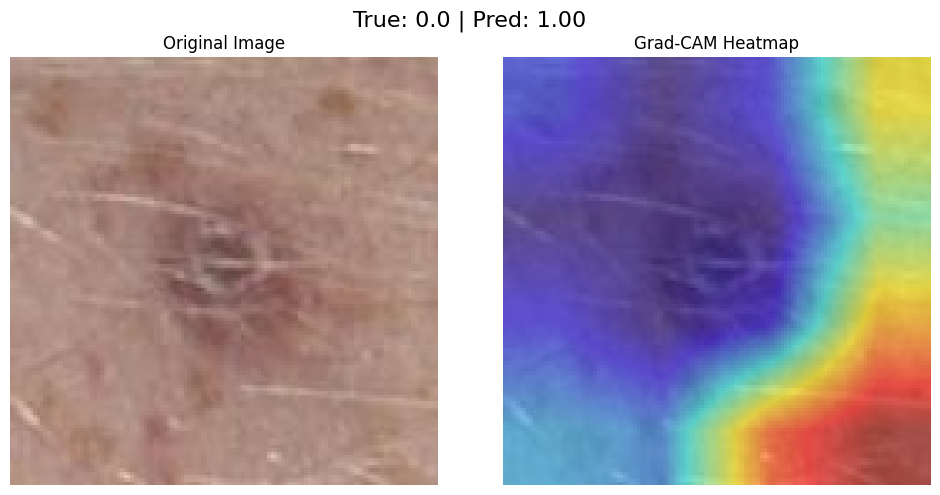

In [57]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, AblationCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

import albumentations as A
from albumentations.pytorch import ToTensorV2
from functools import partial
# ------------------- CONFIG -------------------
chosen_layer = dict(model.encoder.named_modules())["stages_3.blocks.2.convs.2"]
# chosen_layer = dict(model.seg_decoder.named_modules())["out_conv"]

# chosen_layer = model.seg_decoder.final_up1[1]  # Conv2d layer

# Load fold 0 valid data
tsp = StratifiedGroupKFold(2, shuffle=True, random_state=CONFIG['seed'])

for fold_n, (train_idx, val_idx) in enumerate(tsp.split(df_train, y=df_train.target, groups=df_train[CONFIG["group_col"]])):
    if fold_n == 0:
        fold_df_valid = df_train.iloc[val_idx].reset_index(drop=True)
        break

# Pick one image (e.g., high confidence from oof)
# Load preds & targets
tmp_predictions_all = np.load(os.path.join(folder_name, "preds_fold0.npy"))
targets = np.load(os.path.join(folder_name, "targets_fold0.npy"))
# Find index of highest confidence prediction
top_idx = tmp_predictions_all.argmax()
# Get info from fold_df_valid
img_path = fold_df_valid.iloc[top_idx]['path']
true_label = float(targets[top_idx])
pred_score = float(tmp_predictions_all[top_idx])


# ------------------- IMAGE PREP -------------------
image = Image.open(img_path).convert("RGB")
original_size = image.size
img_np = np.array(image)

# Resize + normalize (same as training)
transform = A.Compose([
    A.Resize(CONFIG['img_size'], CONFIG['img_size']),
    A.Normalize(),
    ToTensorV2()
])
transformed = transform(image=img_np)
input_tensor = transformed['image'].unsqueeze(0).to(device)

# Also prepare image in [0,1] float format for visualization
resized_img = image.resize((CONFIG['img_size'], CONFIG['img_size']))
rgb_img = np.float32(resized_img) / 255.0

# ------------------- GRADCAM -------------------
cam = GradCAM(model=model, target_layers=[chosen_layer])
# cam = AblationCAM(model=model, target_layers=[chosen_layer])
targets = [ClassifierOutputTarget(0)]  # Class 0 GradCAM, change as needed

# grayscale_cam = cam.forward(input_tensor=input_tensor, targets=None, extra_forward_args=(True,))[0]
grayscale_cam = cam(input_tensor=input_tensor)[0]
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# ------------------- PLOT -------------------
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(resized_img)
plt.title("Original Image")
plt.axis("off")

# Grad-CAM Heatmap Overlay
plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.suptitle(f"True: {true_label} | Pred: {pred_score:.2f}", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# import os
# import torch
# import numpy as np
# from PIL import Image
# from torchvision import transforms
# from tqdm import tqdm

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Load Model
# model = setup_model(
#     model_name="edgenext_base.in21k_ft_in1k",
#     drop_path_rate=0.0,
#     drop_rate=0.0,
#     model_maker=ISICModelPrep
# )

# checkpoint_path = "../weights/oof_edgenext_sac_unet/model__0"
# model.load_state_dict(torch.load(checkpoint_path, map_location=device))
# model.eval().to(device)

# # Input and Output Folders
# input_folder = "../error_samples/fp/"
# output_folder = "../error_samples/fp_masks/"
# os.makedirs(output_folder, exist_ok=True)

# # Image Transform (resize as per your training config)
# transform = transforms.Compose([
#     transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Inference Loop
# for img_name in tqdm(os.listdir(input_folder)):
#     img_path = os.path.join(input_folder, img_name)
    
#     image = Image.open(img_path).convert("RGB")
#     input_tensor = transform(image).unsqueeze(0).to(device)

#     # Predict segmentation mask
#     with torch.no_grad():
#         _, seg_logits = model(input_tensor, seg=True)
#         mask = seg_logits.sigmoid().squeeze().cpu().numpy()  # [H, W] float mask between 0-1

#     # Optional: Threshold the mask
#     mask = (mask > 0.5).astype(np.uint8) * 255  # convert to 0 or 255 for visualization

#     # Resize back to original size
#     mask_img = Image.fromarray(mask)
#     mask_img = mask_img.resize(image.size)

#     # Save mask
#     save_path = os.path.join(output_folder, img_name.replace('.jpg', '.png').replace('.jpeg', '.png'))
#     mask_img.save(save_path)


Encoder feature dimensions: [80, 160, 288, 584]


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([1, 64, 4, 4])

 40%|████      | 4/10 [00:00<00:00, 35.31it/s]


torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 64, 64])
torch.Size([1, 64, 128, 128])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 64, 64])
torch.Size([1, 64, 128, 128])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 64, 64])
torch.Size([1, 64, 128, 128])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 64, 64])
torch.Size([1, 64, 128, 128])
torch.Size([1, 64, 4, 4])
torch.S

100%|██████████| 10/10 [00:00<00:00, 49.73it/s]


## FP Error Analysis

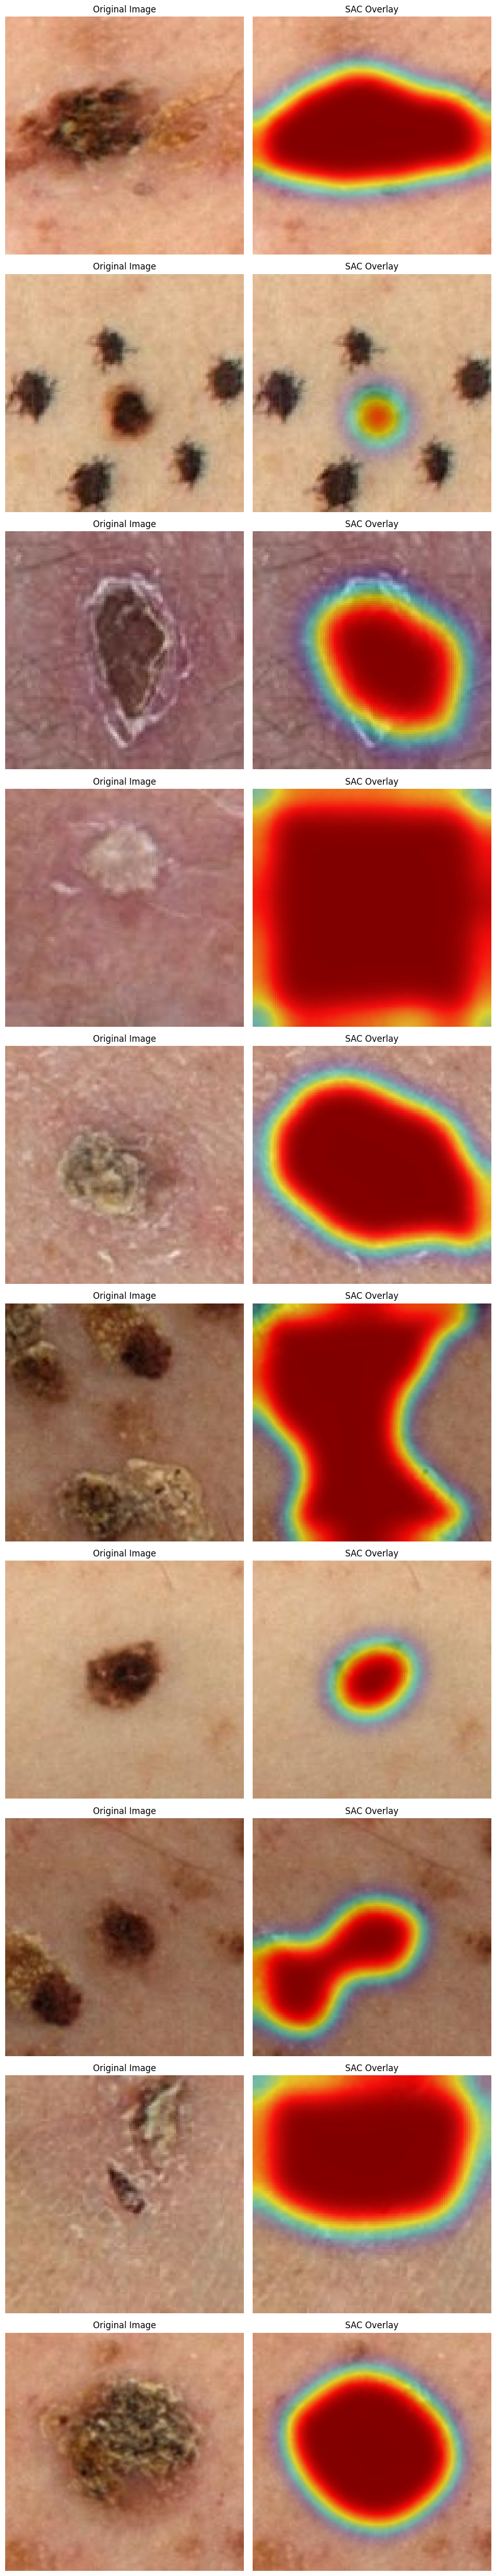

In [49]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

input_folder = "../error_samples/fp/"
mask_sac_folder = "../error_samples/fp_masks/"

image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg'))]

plot_images = []
plot_sac_overlays = []

def generate_overlay(mask_path, image):
    mask = np.array(Image.open(mask_path).convert("L"))
    mask = mask / 255.0
    mask = cv2.GaussianBlur(mask, (51, 51), 0)
    mask_uint8 = (mask * 255).astype(np.uint8)

    heatmap = cv2.applyColorMap(mask_uint8, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    image_float = image / 255.0
    heatmap_float = heatmap / 255.0

    overlay = heatmap_float * mask[..., np.newaxis] + image_float * (1 - mask[..., np.newaxis])
    overlay = (overlay * 255).astype(np.uint8)
    return overlay

for img_name in image_files:
    img_path = os.path.join(input_folder, img_name)
    mask_sac_path = os.path.join(mask_sac_folder, img_name.replace('.jpg', '.png').replace('.jpeg', '.png'))

    image = np.array(Image.open(img_path).convert("RGB"))
    overlay_sac = generate_overlay(mask_sac_path, image)

    plot_images.append(image)
    plot_sac_overlays.append(overlay_sac)

# ---------------- PLOT ------------------
plt.figure(figsize=(10, len(plot_images) * 5))

for idx in range(len(plot_images)):
    plt.subplot(len(plot_images), 2, idx * 2 + 1)
    plt.imshow(plot_images[idx])
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(len(plot_images), 2, idx * 2 + 2)
    plt.imshow(plot_sac_overlays[idx])
    plt.title("SAC Overlay")
    plt.axis('off')

plt.tight_layout()
plt.show()


## FN Error Analysis

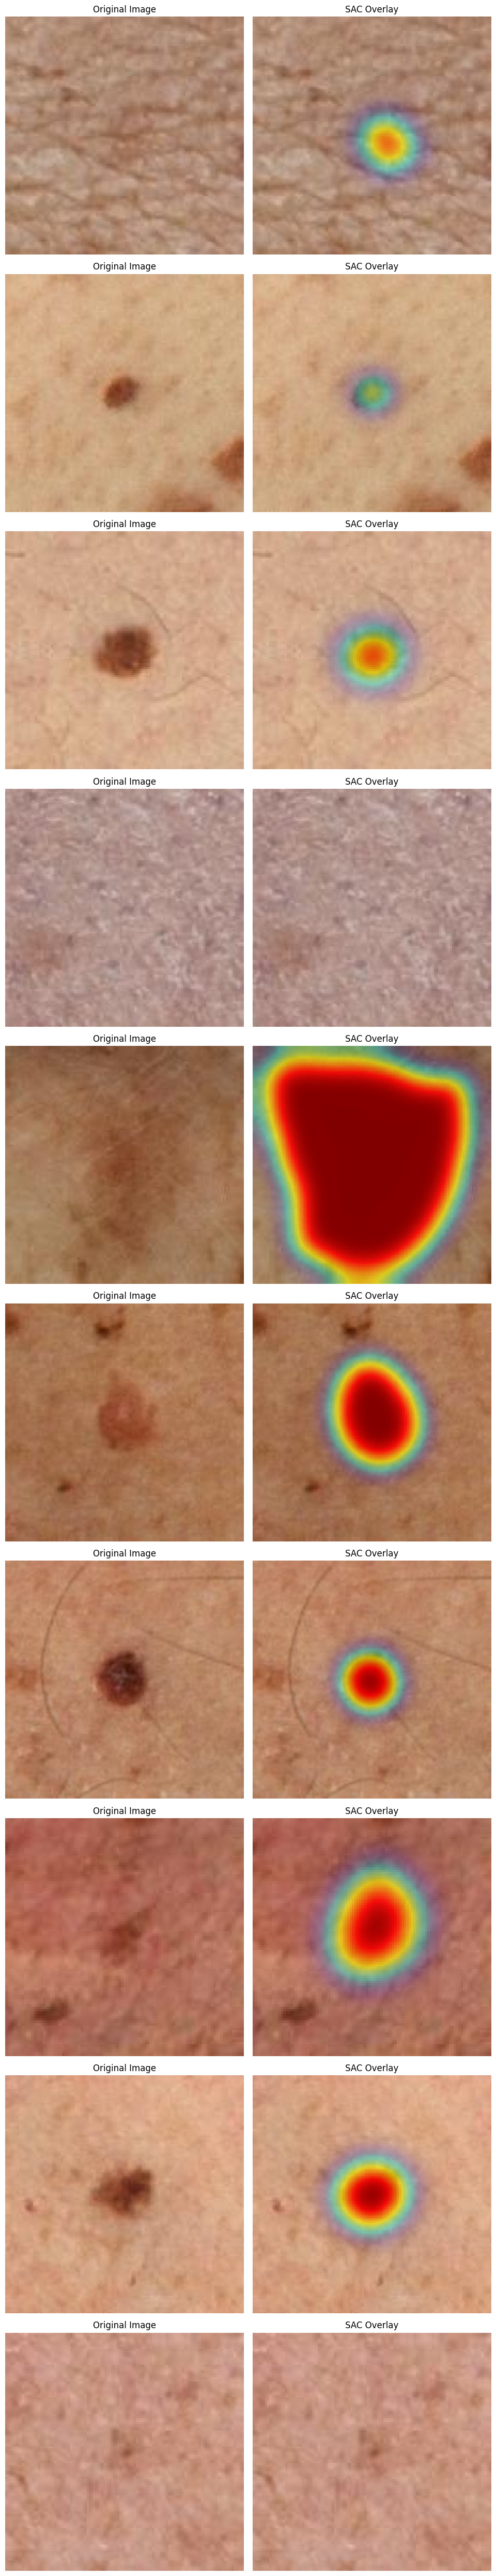

In [50]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

input_folder = "../error_samples/fn/"
mask_sac_folder = "../error_samples/fn_masks/"

image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg'))]

plot_images = []
plot_sac_overlays = []

def generate_overlay(mask_path, image):
    mask = np.array(Image.open(mask_path).convert("L"))
    mask = mask / 255.0
    mask = cv2.GaussianBlur(mask, (51, 51), 0)
    mask_uint8 = (mask * 255).astype(np.uint8)

    heatmap = cv2.applyColorMap(mask_uint8, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    image_float = image / 255.0
    heatmap_float = heatmap / 255.0

    overlay = heatmap_float * mask[..., np.newaxis] + image_float * (1 - mask[..., np.newaxis])
    overlay = (overlay * 255).astype(np.uint8)
    return overlay

for img_name in image_files:
    img_path = os.path.join(input_folder, img_name)
    mask_sac_path = os.path.join(mask_sac_folder, img_name.replace('.jpg', '.png').replace('.jpeg', '.png'))

    image = np.array(Image.open(img_path).convert("RGB"))
    overlay_sac = generate_overlay(mask_sac_path, image)

    plot_images.append(image)
    plot_sac_overlays.append(overlay_sac)

# ---------------- PLOT ------------------
plt.figure(figsize=(10, len(plot_images) * 5))

for idx in range(len(plot_images)):
    plt.subplot(len(plot_images), 2, idx * 2 + 1)
    plt.imshow(plot_images[idx])
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(len(plot_images), 2, idx * 2 + 2)
    plt.imshow(plot_sac_overlays[idx])
    plt.title("SAC Overlay")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import torch
import numpy as np
import pandas as pd
import os
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader
from tqdm import tqdm

def custom_metric_raw(y_hat, y_true):
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

# Load the model
model = setup_model(
    model_name="eva02_small_patch14_336.mim_in22k_ft_in1k",
    drop_path_rate=0.0,
    drop_rate=0.0,
    model_maker=ISICModel  # already defined in your script
)
checkpoint_path = "../weights/oof_eva_base__synth/model__0"
model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'))
model.eval().to(device)

NUM_FOLDS = 3
models_folder = "../weights/oof_eva_base__synth/"
# === Load Metadata ===
df = pd.read_csv("../data/original/train-metadata.csv")
df = df.dropna(subset=["target", CONFIG["group_col"]])  # safety

# === Fold Split ===
tsp = StratifiedGroupKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=CONFIG["seed"])
folds = list(tsp.split(df, y=df["target"], groups=df[CONFIG["group_col"]]))

auroc_scores = []
pauc_scores = []
weight_path = os.path.join(models_folder, f"model__0")

for fold_n, (train_idx, val_idx) in enumerate(folds):
    print(f"\n===== Fold {fold_n} =====")

    df_valid = df.iloc[val_idx].reset_index(drop=True)
    df_valid['path'] = df_valid['isic_id'].apply(lambda x: f"../data/original/train-image/image/{x}.jpg")
    valid_dataset = ISICDatasetSimple(df_valid, transforms=data_transforms["valid"])

    valid_loader = DataLoader(
        valid_dataset, 
        batch_size=CONFIG['valid_batch_size'], 
        shuffle=False,
        num_workers=4, 
        pin_memory=True
    )
    
    preds = []
    targets = []

    with torch.no_grad():
        for batch in tqdm(valid_loader, desc=f"Predicting Fold {fold_n}"):
            inputs = batch["image"].to(CONFIG["device"])
            labels = batch["target"].cpu().numpy()
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).squeeze().detach().cpu().numpy()
            preds.extend(probs if probs.ndim == 1 else probs.tolist())
            targets.extend(labels)

    preds = np.array(preds)
    targets = np.array(targets)

    auroc = roc_auc_score(targets, preds)
    pauc = custom_metric_raw(preds, targets)

    print(f"Fold {fold_n} AUROC: {auroc:.5f}")
    print(f"Fold {fold_n} pAUC : {pauc:.5f}")

    auroc_scores.append(auroc)
    pauc_scores.append(pauc)

print("\n==== Cross Validation Summary ====")
for i in range(NUM_FOLDS):
    print(f"Fold {i}: AUROC = {auroc_scores[i]:.5f}, pAUC = {pauc_scores[i]:.5f}")

print(f"\nMean AUROC: {np.mean(auroc_scores):.5f} ± {np.std(auroc_scores):.5f}")
print(f"Mean pAUC : {np.mean(pauc_scores):.5f} ± {np.std(pauc_scores):.5f}")

C:\Users\mdzh1\AppData\Local\Temp\ipykernel_8164\1465221594.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_locati


===== Fold 0 =====


Predicting Fold 0: 100%|██████████| 1030/1030 [06:37<00:00,  2.59it/s]


Fold 0 AUROC: 0.96130
Fold 0 pAUC : 0.17342

===== Fold 1 =====


Predicting Fold 1: 100%|██████████| 1076/1076 [06:52<00:00,  2.61it/s]


Fold 1 AUROC: 0.93261
Fold 1 pAUC : 0.15007

===== Fold 2 =====


Predicting Fold 2: 100%|██████████| 1028/1028 [06:51<00:00,  2.50it/s]

Fold 2 AUROC: 0.95316
Fold 2 pAUC : 0.16648

==== Cross Validation Summary ====
Fold 0: AUROC = 0.96130, pAUC = 0.17342
Fold 1: AUROC = 0.93261, pAUC = 0.15007
Fold 2: AUROC = 0.95316, pAUC = 0.16648

Mean AUROC: 0.94902 ± 0.01207
Mean pAUC : 0.16332 ± 0.00979


## Effect of SAC

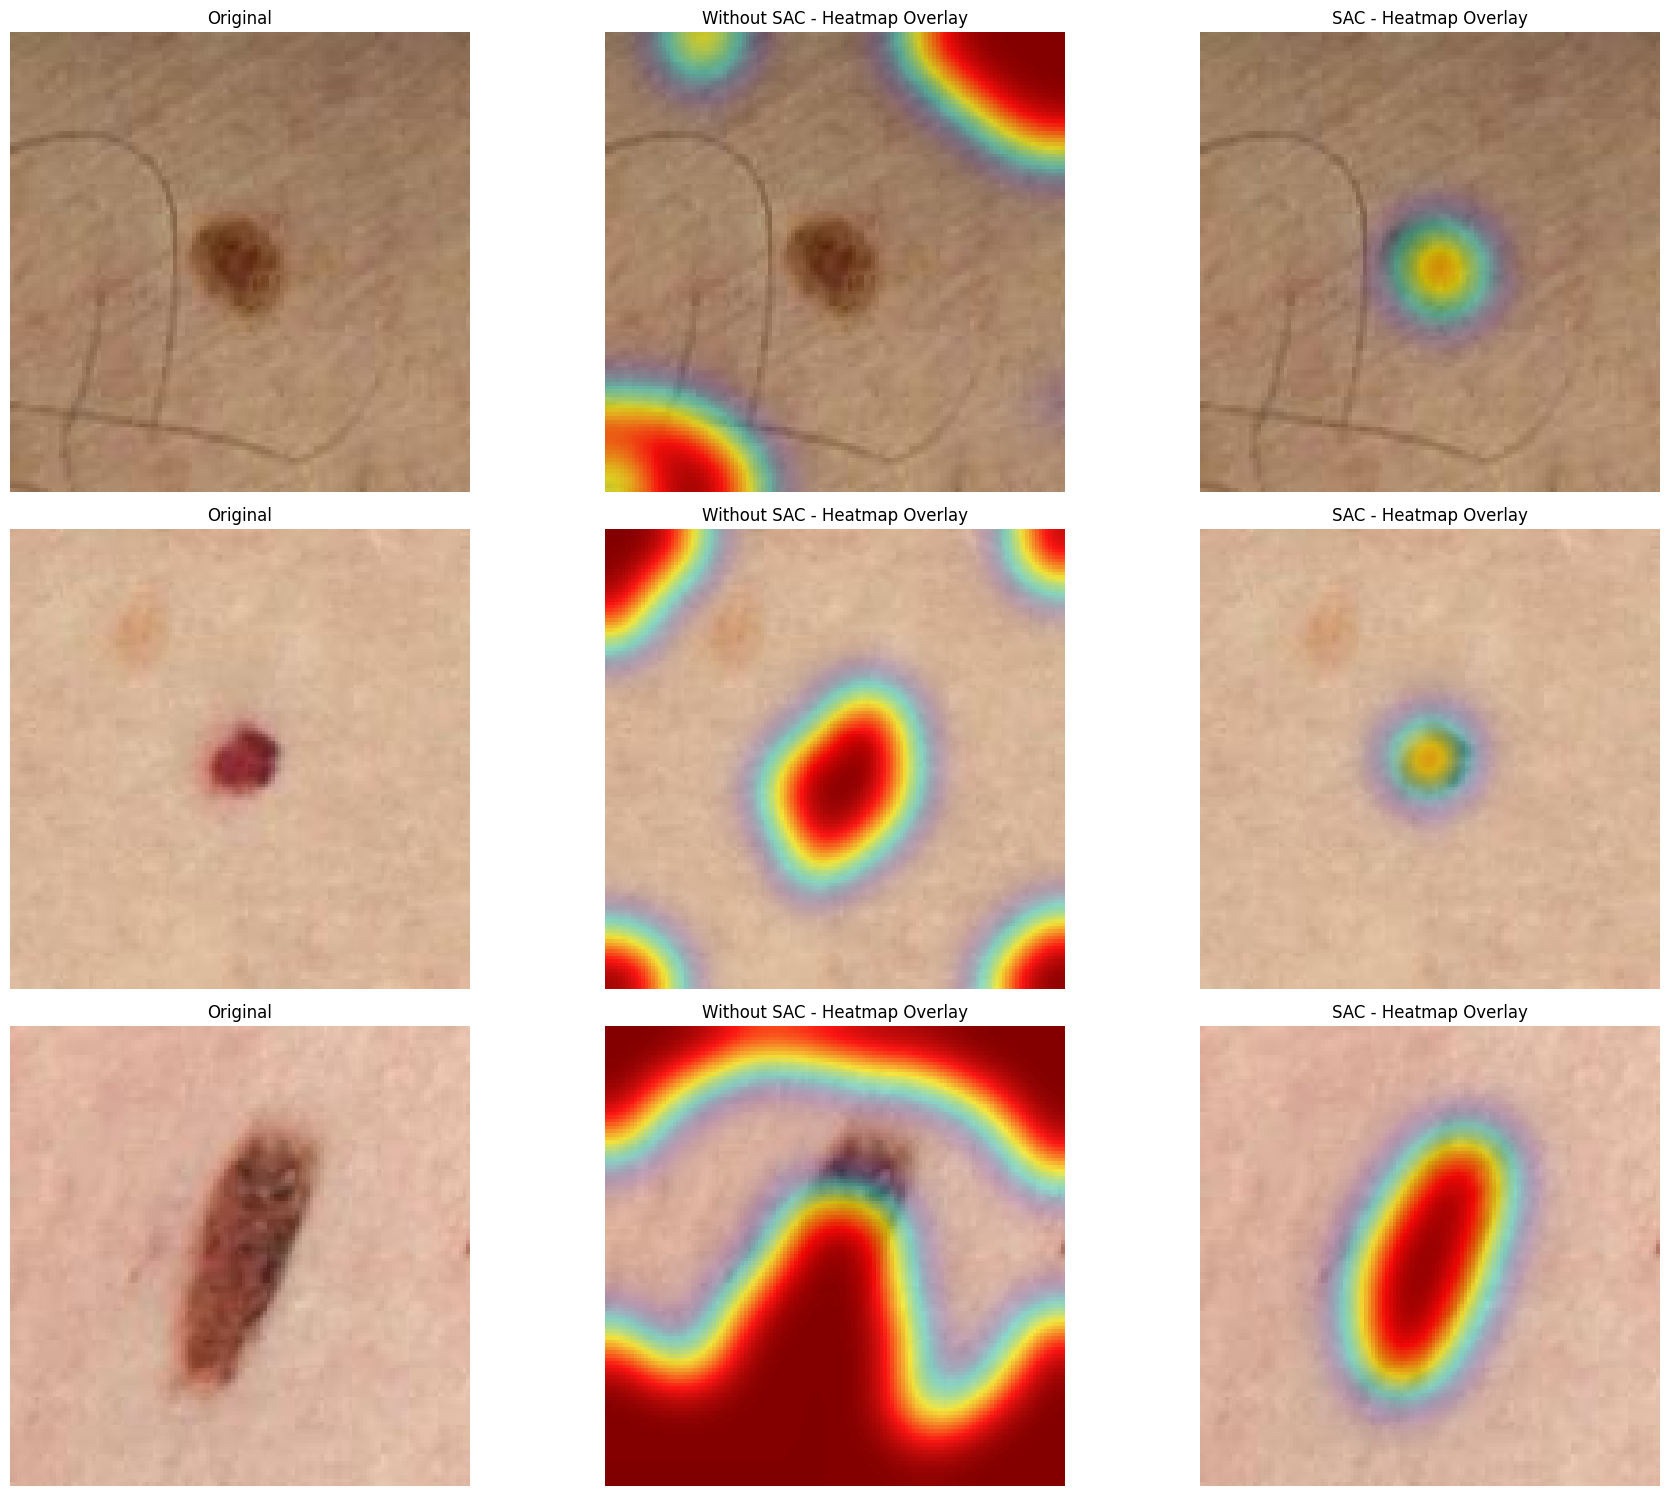

In [69]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

input_folder = "../sample/"
mask_sac_folder = "../sample/"
mask_nonsac_folder = "../sample1/masks/"

image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg'))]

plot_images = []
plot_sac_overlays = []
plot_nonsac_overlays = []

for idx, img_name in enumerate(image_files):
    if idx >= 3:
        break  # Only first 5 images

    img_path = os.path.join(input_folder, img_name)
    mask_sac_path = os.path.join(mask_sac_folder, img_name.replace('.jpg', '.png').replace('.jpeg', '.png'))
    mask_nonsac_path = os.path.join(mask_nonsac_folder, img_name.replace('.jpg', '.png').replace('.jpeg', '.png'))

    # Load Image
    image = np.array(Image.open(img_path).convert("RGB"))

    # Function to create overlay heatmap
    def generate_overlay(mask_path, image):
        mask = np.array(Image.open(mask_path).convert("L"))
        mask = mask / 255.0
        mask = cv2.GaussianBlur(mask, (51, 51), 0)
        mask_uint8 = (mask * 255).astype(np.uint8)

        heatmap = cv2.applyColorMap(mask_uint8, cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        image_float = image / 255.0
        heatmap_float = heatmap / 255.0

        overlay = heatmap_float * mask[..., np.newaxis] + image_float * (1 - mask[..., np.newaxis])
        overlay = (overlay * 255).astype(np.uint8)
        return overlay

    overlay_sac = generate_overlay(mask_sac_path, image)
    overlay_nonsac = generate_overlay(mask_nonsac_path, image)

    # Store for plotting
    plot_images.append(image)
    plot_sac_overlays.append(overlay_sac)
    plot_nonsac_overlays.append(overlay_nonsac)

# ---------------- PLOT ------------------
plt.figure(figsize=(18, 25))

for idx in range(3):
    plt.subplot(5, 3, idx * 3 + 1)
    plt.imshow(plot_images[idx])
    plt.title("Original")
    plt.axis('off')

    plt.subplot(5, 3, idx * 3 + 2)
    plt.imshow(plot_nonsac_overlays[idx])
    plt.title("Without SAC - Heatmap Overlay")
    plt.axis('off')

    plt.subplot(5, 3, idx * 3 + 3)
    plt.imshow(plot_sac_overlays[idx])
    plt.title("SAC - Heatmap Overlay")
    plt.axis('off')

plt.tight_layout()
plt.show()


Total rows = 401059, Unique isic_id = 401059
Encoder feature dimensions: [80, 160, 288, 584]
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 64, 64])
torch.Size([1, 64, 64, 64])
torch.Size([1, 64, 128, 128])
torch.Size([1, 64, 256, 256])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 64, 64])
torch.Size([1, 64, 64, 64])
torch.Size([1, 64, 128, 128])
torch.Size([1, 64, 256, 256])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 64, 64])
torch.Size([1, 64, 64, 64])
torch.Size([1, 64, 128, 128])
torch.Size([1, 64, 256, 256])
torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.S

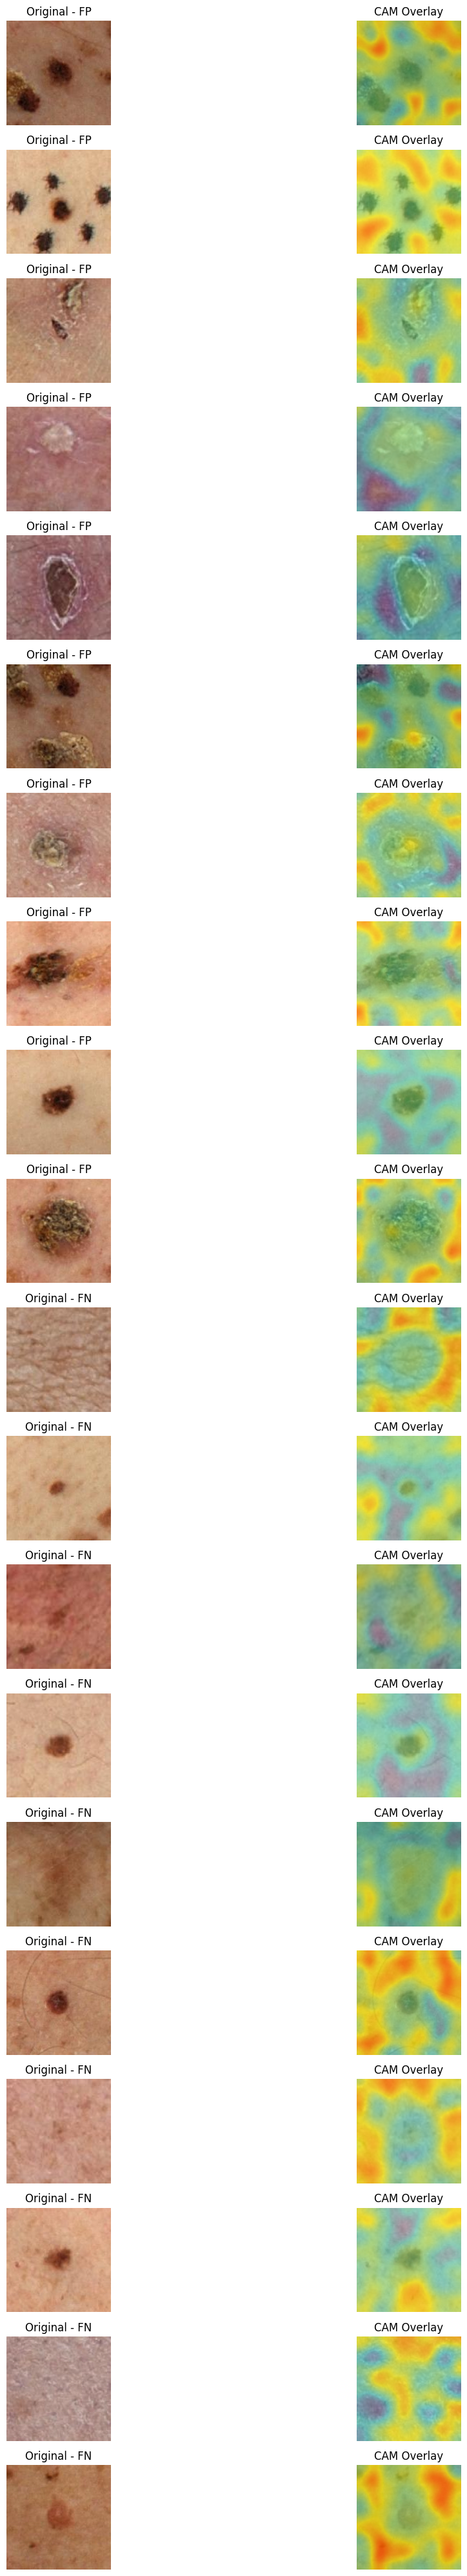

In [47]:
import pandas as pd
import numpy as np
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from functools import partial
from sklearn.metrics import roc_auc_score

# --- 1. Load OOF preds ---
model_flag = "edgenext"
file_path = f"../data/artifacts/oof_forecasts_{model_flag}_base_synth_hr.parquet"

df = pd.read_parquet(file_path)
print(f"Total rows = {len(df)}, Unique isic_id = {df['isic_id'].nunique()}")

ensemble_df = df.groupby('isic_id').agg({
    'tmp_predictions_all': 'mean',
    'tmp_targets_all': 'first'
}).reset_index()

ensemble_df['error_type'] = 'correct'
ensemble_df.loc[(ensemble_df['tmp_predictions_all'] >= 0.5) & (ensemble_df['tmp_targets_all'] == 0), 'error_type'] = 'FP'
ensemble_df.loc[(ensemble_df['tmp_predictions_all'] < 0.5) & (ensemble_df['tmp_targets_all'] == 1), 'error_type'] = 'FN'

# print(ensemble_df['error_type'].value_counts())

# --- 2. Pick top-10 worst FP & FN ---
FP = ensemble_df[ensemble_df.error_type == 'FP'].sort_values(by='tmp_predictions_all', ascending=False).head(10)
FN = ensemble_df[ensemble_df.error_type == 'FN'].sort_values(by='tmp_predictions_all', ascending=True).head(10)

error_samples = pd.concat([FP, FN])

# print(error_samples)

# --- 3. Model Setup (your original code) ---
model = setup_model(
    model_name="edgenext_base.in21k_ft_in1k",
    drop_path_rate=0.0,
    drop_rate=0.0,
    model_maker=ISICModelTimmSeg
)

checkpoint_path = "../weights/oof_edgenext_sac_unet/model__0"
model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'))
model.eval().to(device)
model_with_seg = partial(model.forward, seg=True)

# --- 4. Heatmap Generation ---
def generate_overlay(mask, image):
    mask = mask / 255.0
    mask = cv2.GaussianBlur(mask, (51, 51), 0)
    mask_uint8 = (mask * 255).astype(np.uint8)

    heatmap = cv2.applyColorMap(mask_uint8, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = heatmap / 255.0 * mask[..., None] + image / 255.0 * (1 - mask[..., None])
    overlay = (overlay * 255).astype(np.uint8)
    return overlay

input_folder = "../data/original/train-image/image"  # path where your images are stored
mask_folder = "../data/masks/"    # path where CAM masks are stored/generated


transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Define input_size (e.g., 512)
    transforms.ToTensor(),
])

plot_images = []
plot_overlays = []

for isic_id in error_samples['isic_id']:
    img_path = os.path.join(input_folder, f"{isic_id}.jpg")

    # Load image
    image = Image.open(img_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Model prediction with CAM
    with torch.no_grad():
        logits, cam_mask = model_with_seg(image_tensor)
        cam_mask = cam_mask.squeeze().detach().cpu().numpy()  # (H, W)

    image_np = np.array(image)
    cam_mask_resized = cv2.resize(cam_mask, (image_np.shape[1], image_np.shape[0]))
    cam_mask_resized = (cam_mask_resized * 255).astype(np.uint8)

    overlay = generate_overlay(cam_mask_resized, image_np)

    plot_images.append(image_np)
    plot_overlays.append(overlay)

# --- 5. Plot the Images ---
plt.figure(figsize=(15, 40))

for idx in range(len(plot_images)):
    plt.subplot(len(plot_images), 2, idx * 2 + 1)
    plt.imshow(plot_images[idx])
    plt.title(f"Original - {error_samples.iloc[idx].error_type}")
    plt.axis('off')

    plt.subplot(len(plot_images), 2, idx * 2 + 2)
    plt.imshow(plot_overlays[idx])
    plt.title("CAM Overlay")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [20]:
import os
import shutil
import pandas as pd

# === Setup paths ===
original_dir = "../data/original/train-image/image/"         # where original ISIC images are stored
fp_dir = "../error_samples/fp/"
fn_dir = "../error_samples/fn/"

# Create output folders if not exist
os.makedirs(fp_dir, exist_ok=True)
os.makedirs(fn_dir, exist_ok=True)

# === Copy files ===
for row in error_samples.itertuples(index=False):
    isic_id, pred, true, error_type = row
    src = os.path.join(original_dir, f"{isic_id}.jpg")

    if error_type == "FP":
        dst = os.path.join(fp_dir, f"{isic_id}.jpg")
    else:
        dst = os.path.join(fn_dir, f"{isic_id}.jpg")

    if os.path.exists(src):
        shutil.copy(src, dst)
        print(f"Copied {isic_id}.jpg to {error_type} folder.")
    else:
        print(f"[Missing] {isic_id}.jpg not found in source folder.")


Copied ISIC_8854926.jpg to FP folder.
Copied ISIC_3335254.jpg to FP folder.
Copied ISIC_9030647.jpg to FP folder.
Copied ISIC_5556712.jpg to FP folder.
Copied ISIC_5119174.jpg to FP folder.
Copied ISIC_6620562.jpg to FP folder.
Copied ISIC_5662885.jpg to FP folder.
Copied ISIC_0498962.jpg to FP folder.
Copied ISIC_8358942.jpg to FP folder.
Copied ISIC_9363448.jpg to FP folder.
Copied ISIC_0287900.jpg to FN folder.
Copied ISIC_3266736.jpg to FN folder.
Copied ISIC_6424909.jpg to FN folder.
Copied ISIC_3288933.jpg to FN folder.
Copied ISIC_4867539.jpg to FN folder.
Copied ISIC_5419141.jpg to FN folder.
Copied ISIC_7836717.jpg to FN folder.
Copied ISIC_7834218.jpg to FN folder.
Copied ISIC_3964079.jpg to FN folder.
Copied ISIC_5328578.jpg to FN folder.


# MISC

In [93]:

encoder = timm.create_model(
            model_name="edgenext_base.in21k_ft_in1k",
            pretrained=True,
            num_classes=0,         # remove head
            global_pool=None,      # remove global pooling
            features_only=True,    # get multi-scale features
            out_indices=(0, 1, 2, 3)
        )
feature_dim = encoder.feature_info[-1]['num_chs']
feature_dim

584

In [ ]:
def get_metrics(drop_path_rate, drop_rate, models_folder, model_maker):
    # Use StratifiedGroupKFold as before.
    tsp = StratifiedGroupKFold(2, shuffle=True, random_state=CONFIG['seed'])
    results_list = []
    fold_df_valid_list = []
    
    for fold_n, (train_index, val_index) in enumerate(tsp.split(df_train, y=df_train.target, groups=df_train[CONFIG["group_col"]])):
        fold_df_train = df_train.iloc[train_index].reset_index(drop=True)
        fold_df_valid = df_train.iloc[val_index].reset_index(drop=True)
        
        # -- For quick testing: Sample a balanced subset from train and validation.
        # Adjust n_samples as needed (e.g., 20 per class)
        n_samples_per_class = 20
        train_subset = pd.concat([
            fold_df_train[fold_df_train.target == 0].sample(n=n_samples_per_class, random_state=CONFIG['seed']),
            fold_df_train[fold_df_train.target == 1].sample(n=n_samples_per_class, random_state=CONFIG['seed'])
        ]).reset_index(drop=True)
        valid_subset = pd.concat([
            fold_df_valid[fold_df_valid.target == 0].sample(n=n_samples_per_class, random_state=CONFIG['seed']),
            fold_df_valid[fold_df_valid.target == 1].sample(n=n_samples_per_class, random_state=CONFIG['seed'])
        ]).reset_index(drop=True)
        
        fold_df_train = train_subset
        fold_df_valid = valid_subset

        set_seed(CONFIG['seed'])
        model = setup_model(model_name, drop_path_rate=drop_path_rate, drop_rate=drop_rate, model_maker=model_maker)
        print_trainable_parameters(model)
        
        # Prepare loaders using the subsets
        train_loader, valid_loader = prepare_loaders(fold_df_train, fold_df_valid, CONFIG, data_transforms)
        
        optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], 
                           weight_decay=CONFIG['weight_decay'])
        scheduler = fetch_scheduler(optimizer, CONFIG)
        
        # Run training with a low number of train and validation steps for quick testing.
        model, history = run_training(
            train_loader, valid_loader,
            model, optimizer, scheduler,
            device=CONFIG['device'],
            num_epochs=CONFIG['epochs'],
            CONFIG=CONFIG, 
            tolerance_max=20,
            test_every_nth_step=lambda x: 5,
            seed=CONFIG['seed'],
            criterion=combined_criterion
        )
        torch.save(model.state_dict(), os.path.join(models_folder, f"model__{fold_n}"))

        # Save history as JSON
        with open(os.path.join(models_folder, f"history__{fold_n}.json"), "w") as f:
            json.dump(history, f)

        results_list.append(np.max(history['Valid Kaggle metric']))

        val_epoch_loss, val_epoch_auroc, val_epoch_custom_metric, tmp_predictions_all, tmp_targets_all = valid_one_epoch(
            model, 
            valid_loader, 
            device=CONFIG['device'], 
            epoch=1, 
            optimizer=optimizer, 
            criterion=combined_criterion, 
            use_custom_score=True,
            metric_function=binary_auroc, 
            num_classes=1,
            return_preds=True
                            )
        
        # Save predictions/targets
        np.save(os.path.join(models_folder, f"preds_fold{fold_n}.npy"), tmp_predictions_all)
        np.save(os.path.join(models_folder, f"targets_fold{fold_n}.npy"), tmp_targets_all)

        # Save CAM-worthy top predictions
        cam_dir = f"{models_folder}/cam_samples/fold{fold_n}"
        os.makedirs(cam_dir, exist_ok=True)
        top_idxs = np.argsort(-tmp_predictions_all)[:10]
        for i in top_idxs:
            img_path = fold_df_valid.iloc[i].path
            target = fold_df_valid.iloc[i].target
            img_name = os.path.basename(str(fold_df_valid.iloc[i].path))  # ensure path is a string
            target_val = float(target) if isinstance(target, np.ndarray) else target
            save_name = f"{cam_dir}/target{target_val}_conf_{float(tmp_predictions_all[i]):.2f}_{img_name}"
            try:
                shutil.copy(img_path, save_name)
            except:
                pass
        
        fold_df_valid['tmp_targets_all'] = tmp_targets_all
        fold_df_valid['tmp_predictions_all'] = tmp_predictions_all
        fold_df_valid['fold_n'] = fold_n
        fold_df_valid_list.append(fold_df_valid)
        
        # Break after processing the first fold for testing purposes.
        break
    
    fold_df_valid_list = pd.concat(fold_df_valid_list).reset_index(drop=True)
    return results_list, fold_df_valid_list

base_metrics, oof_forecasts = get_metrics(drop_path_rate=0, drop_rate=0, models_folder=folder_name, model_maker=ISICModelPrep)
oof_forecasts.to_parquet(f'../data/artifacts/oof_forecasts_{MODEL_NAME.lower()}_sac_unet.parquet')


trainable params: 18366798 || all params: 18366798 || trainable%: 100.00


  0%|          | 0/20 [00:00<?, ?it/s]

0.8027058839797974
Seg loss: 0.7408286929130554


 10%|█         | 2/20 [00:00<00:05,  3.23it/s, Epoch=1, LR=0.0001, Train_Auroc=0.25, Train_Loss=2.03]

1.7015693187713623
Seg loss: 0.8172180652618408


 25%|██▌       | 5/20 [00:00<00:01,  8.90it/s, Epoch=1, LR=0.0001, Train_Auroc=0.5, Train_Loss=2.37]  

0.17999064922332764
Seg loss: 0.8087314367294312
3.4760873317718506
Seg loss: 0.7306927442550659
1.6158757209777832
Seg loss: 0.8797767758369446
0.6458326578140259
Seg loss: 0.7589954137802124
0.709530770778656
Seg loss: 0.7043900489807129
3.581759452819824
Seg loss: 0.8180346488952637
2.269132137298584
Seg loss: 0.5170919895172119


 65%|██████▌   | 13/20 [00:01<00:00, 20.72it/s, Epoch=1, LR=0.0001, Train_Auroc=0.5, Train_Loss=1.99]  

0.18856510519981384
Seg loss: 0.8094850778579712
1.7418025732040405
Seg loss: 0.6002497673034668
0.2512126863002777
Seg loss: 0.6906791925430298
0.6171615123748779
Seg loss: 0.7915458083152771
0.5154394507408142
Seg loss: 0.7175877094268799
0.39204615354537964
Seg loss: 0.7063570022583008
0.5253997445106506
Seg loss: 0.9169118404388428


 85%|████████▌ | 17/20 [00:01<00:00, 23.78it/s, Epoch=1, LR=0.0001, Train_Auroc=0.5, Train_Loss=1.89]  

2.0757029056549072
Seg loss: 0.702811062335968
1.114136815071106
Seg loss: 0.8231452703475952
0.5153430104255676
Seg loss: 0.5618576407432556
0.2229645699262619
Seg loss: 0.5703040361404419


100%|██████████| 20/20 [00:01<00:00, 11.74it/s, Epoch=1, LR=0.0001, Train_Auroc=0.5, Train_Loss=1.89]


  5%|▌         | 1/20 [00:00<00:05,  3.66it/s, Epoch=2, LR=0.0001, Train_Auroc=0.5, Train_Loss=1.52]

0.8959954977035522
Seg loss: 0.6204977035522461
0.7496256828308105
Seg loss: 0.6183975338935852


 15%|█▌        | 3/20 [00:00<00:02,  7.91it/s, Epoch=2, LR=0.0001, Train_Auroc=0.667, Train_Loss=1.38]

0.6524362564086914
Seg loss: 0.703450083732605
0.3333294689655304
Seg loss: 0.8213487863540649
1.2701473236083984
Seg loss: 0.5741145610809326
0.37582436203956604
Seg loss: 0.6623975038528442
0.8340244889259338
Seg loss: 0.6306623816490173


 55%|█████▌    | 11/20 [00:00<00:00, 22.51it/s, Epoch=2, LR=9.99e-5, Train_Auroc=0.615, Train_Loss=1.35]

1.6453735828399658
Seg loss: 0.8399444818496704
0.010587720200419426
Seg loss: 0.46641042828559875
0.8005256652832031
Seg loss: 0.5586135387420654
0.642070472240448
Seg loss: 0.8625277280807495
0.26856404542922974
Seg loss: 0.6994853019714355
0.14370417594909668
Seg loss: 0.8309825658798218
0.09731023758649826
Seg loss: 0.641703188419342


 90%|█████████ | 18/20 [00:00<00:00, 26.89it/s, Epoch=2, LR=9.99e-5, Train_Auroc=0.575, Train_Loss=1.28]

0.055830638855695724
Seg loss: 0.6365827322006226
1.9964203834533691
Seg loss: 0.7693395018577576
0.11310524493455887
Seg loss: 0.826665997505188
0.021756183356046677
Seg loss: 0.761299729347229
0.4416876435279846
Seg loss: 0.7839397192001343
0.043235279619693756
Seg loss: 0.9481239318847656


100%|██████████| 20/20 [00:01<00:00, 14.04it/s, Epoch=2, LR=9.99e-5, Train_Auroc=0.575, Train_Loss=1.28]


  5%|▌         | 1/20 [00:00<00:05,  3.28it/s, Epoch=3, LR=9.99e-5, Train_Auroc=0.5, Train_Loss=1.71]

1.120124340057373
Seg loss: 0.592427670955658
0.15097644925117493
Seg loss: 0.6642768383026123


 30%|███       | 6/20 [00:00<00:01, 13.52it/s, Epoch=3, LR=9.99e-5, Train_Auroc=0.562, Train_Loss=0.869]

0.11800287663936615
Seg loss: 0.6463115811347961
0.11683627963066101
Seg loss: 0.8526392579078674
0.05783097445964813
Seg loss: 0.6936350464820862
0.1537802368402481
Seg loss: 0.5408918857574463
0.012044591829180717
Seg loss: 0.48674941062927246
0.07215557992458344
Seg loss: 0.671088695526123
0.08014767616987228
Seg loss: 0.5559612512588501


 70%|███████   | 14/20 [00:00<00:00, 23.82it/s, Epoch=3, LR=9.98e-5, Train_Auroc=0.533, Train_Loss=1.02]

1.105599284172058
Seg loss: 0.8195894956588745
1.4318386316299438
Seg loss: 0.5870332717895508
0.052652932703495026
Seg loss: 0.7897130250930786
0.4848163425922394
Seg loss: 0.4418099522590637
0.4095178246498108
Seg loss: 0.5918875932693481
0.22834302484989166
Seg loss: 0.836590051651001
0.5396808385848999
Seg loss: 0.8573026657104492


 90%|█████████ | 18/20 [00:00<00:00, 27.14it/s, Epoch=3, LR=9.98e-5, Train_Auroc=0.55, Train_Loss=1.08] 

0.6040806770324707
Seg loss: 0.5861784219741821
1.0135780572891235
Seg loss: 0.6497205495834351
0.09537476301193237
Seg loss: 0.6965359449386597
0.5166219472885132
Seg loss: 0.6842905282974243


100%|██████████| 20/20 [00:01<00:00, 13.21it/s, Epoch=3, LR=9.98e-5, Train_Auroc=0.55, Train_Loss=1.08]


  5%|▌         | 1/20 [00:00<00:04,  4.10it/s, Epoch=4, LR=9.98e-5, Train_Auroc=0.5, Train_Loss=0.542]

0.0006013184902258217
Seg loss: 0.5815263390541077
0.0014212109381332994
Seg loss: 0.5000895261764526


 35%|███▌      | 7/20 [00:00<00:00, 17.21it/s, Epoch=4, LR=9.97e-5, Train_Auroc=0.571, Train_Loss=2.22]

6.058382987976074
Seg loss: 0.6649866104125977
2.406562328338623
Seg loss: 0.5523064136505127
0.331290602684021
Seg loss: 0.5597084164619446
0.4453798532485962
Seg loss: 0.6338686943054199
2.0414886474609375
Seg loss: 0.7899963855743408
0.06958194077014923
Seg loss: 0.487713098526001


 50%|█████     | 10/20 [00:00<00:00, 20.96it/s, Epoch=4, LR=9.97e-5, Train_Auroc=0.654, Train_Loss=1.86]

0.10994605720043182
Seg loss: 0.48060521483421326
1.4275438785552979
Seg loss: 0.5939443707466125
2.415677070617676
Seg loss: 0.6016340851783752
0.8989811539649963
Seg loss: 0.797520637512207
0.09012262523174286
Seg loss: 0.5997388958930969
0.43907421827316284
Seg loss: 0.6221386194229126


 90%|█████████ | 18/20 [00:00<00:00, 26.67it/s, Epoch=4, LR=9.96e-5, Train_Auroc=0.6, Train_Loss=1.66]  

0.1249978095293045
Seg loss: 0.7500975728034973
1.3276653289794922
Seg loss: 0.5734813213348389
0.21239717304706573
Seg loss: 0.6182023882865906
0.9733272790908813
Seg loss: 0.5159638524055481
0.7222865223884583
Seg loss: 0.6747621297836304
0.8444820046424866
Seg loss: 0.6774715185165405


100%|██████████| 20/20 [00:01<00:00, 14.28it/s, Epoch=4, LR=9.96e-5, Train_Auroc=0.6, Train_Loss=1.66]


  0%|          | 0/20 [00:00<?, ?it/s]

0.41902637481689453
Seg loss: 0.519206166267395


 25%|██▌       | 5/20 [00:00<00:01, 12.75it/s, Epoch=5, LR=9.95e-5, Train_Auroc=0.571, Train_Loss=1.16]

0.473528653383255
Seg loss: 0.5974106788635254
0.47031646966934204
Seg loss: 0.716299295425415
0.5175625085830688
Seg loss: 0.7617814540863037
0.7021031379699707
Seg loss: 0.569697380065918
0.4719509184360504
Seg loss: 0.7835202813148499
0.6438933610916138
Seg loss: 0.4971880614757538
0.34661760926246643
Seg loss: 0.5219522714614868


 65%|██████▌   | 13/20 [00:00<00:00, 23.14it/s, Epoch=5, LR=9.95e-5, Train_Auroc=0.679, Train_Loss=1.09]

0.27333807945251465
Seg loss: 0.5099245309829712
0.3874456584453583
Seg loss: 0.49511754512786865
0.564530074596405
Seg loss: 0.8253655433654785
0.5795701742172241
Seg loss: 0.5713162422180176
0.433520644903183
Seg loss: 0.5782767534255981
0.353691965341568
Seg loss: 0.6260071992874146


 85%|████████▌ | 17/20 [00:00<00:00, 25.65it/s, Epoch=5, LR=9.94e-5, Train_Auroc=0.684, Train_Loss=1.09]

0.4237583875656128
Seg loss: 0.6845637559890747
0.3653389811515808
Seg loss: 0.46666762232780457
0.6706728935241699
Seg loss: 0.4982888102531433
0.7007571458816528
Seg loss: 0.5368956923484802
0.3781086206436157
Seg loss: 0.7915639877319336
0.25331276655197144
Seg loss: 0.46147745847702026


100%|██████████| 1/1 [00:03<00:00,  3.19s/it, Epoch=5, LR=9.94e-5, Valid_AUROC=0.818, Valid_Loss=1.54]

0.7412809729576111
Seg loss: 0.7994974851608276


100%|██████████| 1/1 [00:04<00:00,  4.06s/it, Epoch=5, LR=9.94e-5, Valid_AUROC=0.818, Valid_Loss=1.54]


Validation AUROC Improved (-inf ---> 0.09499999999999995)

Training complete in 0h 2m 16s
Best AUROC: 0.0950


100%|██████████| 1/1 [00:03<00:00,  3.24s/it, Epoch=1, LR=9.94e-5, Valid_AUROC=0.818, Valid_Loss=1.54]

0.7412809729576111
Seg loss: 0.7994974851608276


100%|██████████| 1/1 [00:03<00:00,  3.98s/it, Epoch=1, LR=9.94e-5, Valid_AUROC=0.818, Valid_Loss=1.54]
